<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/main/CAN_LSTM_Timediff_20240701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리  
- 각 ID별로 Timediff 값 추가
- 몇 ID가 test데이터에 공격데이터의 수가 부족해 테스트가 안되는 문제가 발생
- 따라서 디코딩 과정에서 데이터 수가 너무 많아 split했던 data들을 각 ID별로 concat해서 데이터의 양을 늘림


---  
**<데이터 크기로 인한 split 과정>**  
Pre_train_D_1 ->
  - decoded_can_data_AddDLC_1_0 ->
      - /filtered_data_AddDLC_1_0/pre_train_D_1_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_1_1 ->
      - /filtered_data_AddDLC_1_1/pre_train_D_1_1_ID_{id}   (총 56개)

Pre_train_D_2 ->
  - decoded_can_data_AddDLC_2_0 ->
      - /filtered_data_AddDLC_2_0/pre_train_D_2_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_2_1 ->
      - /filtered_data_AddDLC_2_1/pre_train_D_2_1_ID_{id}   (총 56개)

=> 총 224개의 파일 생성

**<학습을 위한 concat과정>**   
 동일한 id  
combined_df ->
 - pre_train_D_**1_0**_ID_{id} + pre_train_D_**1_1**_ID_{id} + pre_train_D_**2_0**_ID_{id} + pre_train_D_**2_1**_ID_{id}

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 주어진 ID 리스트
ids = ['251', '2B0', '381', '340', '260', '47F', '329', '164', '387', '394',
       '4F1', '130', '140', '356', '153', '220', '367', '368', '412',
       '470', '38D', '420', '421', '389', '386', '492', '391', '485', '490',
       '593', '484', '48A', '50C', '58B', '436', '541', '507', '4A7', '520',
       '53E', '495', '500', '483', '4A2', '50A', '043', '52A', '544',
       '559', '410', '07F', '57F', '5B0']

       # 366, 563, 553

# 빈도수 분포; ID 별 메시지 TimeDelta 값(ms)
can_freqs = {'000': 2.0,
      '043': 1.0, '07F': 1.0, '130': 0.01, '140': 0.01, '153': 0.01, '164': 0.01, '220': 0.01, '251': 0.01,
      '260': 0.01, '2B0': 0.01, '329': 0.01, '340': 0.01, '356': 0.01, '366': 0.01, '367': 0.01, '368': 0.01, '381': 0.02,
      '386': 0.02, '387': 0.02, '389': 0.02, '38D': 0.02, '391': 0.02, '394': 0.02, '410': 0.2, '412': 0.2, '420': 0.02,
      '421': 0.02, '42D': 0.1, '436': 0.05, '44E': 0.2, '453': 0.02, '470': 0.02, '479': 0.1, '47F': 0.02, '483': 0.2,
      '484': 0.07, '485': 0.05, '48A': 0.05, '48C': 0.2, '490': 0.05, '492': 0.05, '495': 0.1, '49F': 0.2, '4A2': 0.5,
      '4A4': 2.0, '4A7': 0.5, '4A9': 0.2, '4C9': 0.2, '4CB': 0.2, '4F1': 0.02, '500': 0.1, '507': 0.1, '50A': 0.2,
      '50C': 0.1, '50E': 0.2, '520': 0.1, '52A': 0.2, '53B': 0.2, '53E': 0.1, '53F': 0.2, '541': 0.1, '544': 0.2,
      '553': 0.2, '559': 0.2, '563': 0.5, '568': 0.1, '572': 0.2, '57F': 1.5, '58B': 0.05, '593': 0.2, '5A6': 0.2,
      '5B0': 1.0, '5BE': 1.0, '5CD': 0.2, '7C4': 2.0, '7CC': 2.0, '7D0': 2.0, '7D4': 2.0, '7D8': 2.0, '7DC': 2.0 }

In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_train = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(1, 3):  # 2개의 폴더를 처리할 것으로 가정
        for j in range(2):  # ID가 0과 1인 두 가지 경우를 처리할 것으로 가정
            file_path = f'/content/drive/MyDrive/CAN/Decoding_data_Timediff_20240627/H-SCOPE/filtered_data_AddDLC_{folder_number}_{j}/pre_train_D_{folder_number}_{j}_ID_{id}.csv'
            try:
                df = pd.read_csv(file_path)
                id_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_train[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_train['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,Checksum,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,...,TQI_MAX,SPK_TIME_CUR,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.007005,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.016660,260,Normal,8,8.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,2.0,0.0,0.009655,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.026868,260,Normal,8,7.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,3.0,0.0,0.010208,0.019863,0.030000,0.040000,0.050000,0.060000
3,0.036675,260,Normal,8,10.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,0.0,0.0,0.009807,0.020015,0.029670,0.040000,0.050000,0.060000
4,0.046681,260,Normal,8,9.0,1.953125,20.312500,0.781250,0.0,0.0,...,73.4375,-2.25,1.0,0.0,0.010006,0.019813,0.030021,0.039676,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66119,167.399959,260,Normal,8,7.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,1.0,0.0,0.010692,0.019379,0.030830,0.040898,0.050214,0.060771
66120,167.409276,260,Normal,8,6.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,2.0,0.0,0.009317,0.020009,0.028696,0.040147,0.050215,0.059531
66121,167.419839,260,Normal,8,5.0,1.953125,16.796875,0.000000,0.0,0.0,...,73.4375,-3.00,3.0,0.0,0.010563,0.019880,0.030572,0.039259,0.050710,0.060778
66122,167.429246,260,Normal,8,7.0,1.953125,16.796875,0.390625,0.0,0.0,...,73.4375,-3.00,0.0,0.0,0.009407,0.019970,0.029287,0.039979,0.048666,0.060117


In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_test = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for i in range(0,6):  # 2개의 폴더를 처리할 것으로 가정
        file_path = f'/content/drive/MyDrive/CAN/submit_filter_data/D{i}/pre_test_D_{i}_ID_{id}.csv'
        try:
            df = pd.read_csv(file_path)
            id_dfs.append(df)
        except FileNotFoundError:
            print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_test[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_test['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,TQI_MIN,TQI,TQI_TARGET,GLOW_STAT,CRUISE_LAMP_M,CRUISE_LAMP_S,...,SPK_TIME_CUR,Checksum,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.000457,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.010557,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,10.0,3.0,0.0,0.010100,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.020474,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,13.0,0.0,0.0,0.009917,0.020017,0.030000,0.040000,0.050000,0.060000
3,0.030472,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,12.0,1.0,0.0,0.009998,0.019915,0.030015,0.040000,0.050000,0.060000
4,0.040468,260,Normal,8,1.953125,14.843750,0.390625,0.0,0.0,0.0,...,-3.0,11.0,2.0,0.0,0.009996,0.019994,0.029911,0.040011,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,96.745680,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,14.0,2.0,0.0,0.010021,0.020041,0.029986,0.040020,0.049973,0.060064
77216,96.755736,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,13.0,3.0,0.0,0.010056,0.020077,0.030097,0.040042,0.050076,0.060029
77217,96.765635,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,0.0,0.0,0.0,0.009899,0.019955,0.029976,0.039996,0.049941,0.059975
77218,96.775676,260,Normal,8,1.953125,18.359375,3.906250,0.0,0.0,0.0,...,-6.0,15.0,1.0,0.0,0.010041,0.019940,0.029996,0.040017,0.050037,0.059982


## 학습, 테스트 데이터 split & 모델 학습

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
# id별 학습 및 테스트 셋
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id):
    # 데이터프레임 선택
    df_combined_train = dfs_by_id_train[f'df_{data_id}_combined']
    df_combined_test = dfs_by_id_test[f'df_{data_id}_combined']

    train_columns = df_combined_train.columns
    df_combined_test = df_combined_test[train_columns]

    # 타겟 변수와 특징 변수 분리
    X_train = df_combined_train.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_train = df_combined_train['SubClass']

    X_test = df_combined_test.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y_test = df_combined_test['SubClass']

    categorical_columns = X_train.select_dtypes(include=['category']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_columns)

    categorical_columns = X_test.select_dtypes(include=['category']).columns
    X_test = pd.get_dummies(X_test, columns=categorical_columns)

    cols = X_train.columns
    # 정규화
    scaler = MinMaxScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_train_scaler = tf.cast(X_train_scaler, tf.float32)

    X_test_scaler = scaler.transform(X_test)
    X_test_scaler = tf.cast(X_test_scaler, tf.float32)

    X_train_df=pd.DataFrame(X_train_scaler, columns=cols)
    X_test_df=pd.DataFrame(X_test_scaler, columns=cols)

    # 원본 차원 정보 : (11078, 6) => 변경된 차원 정보 : (11078, 6, 1)
    # (데이터 개수, Sequence 길이, Input Vector 길이)
    X_train_ex = tf.expand_dims(X_train_df, axis=2)
    X_test_ex = tf.expand_dims(X_test_df, axis=2)

    # 클래스 레이블을 숫자로 인코딩
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)


    return X_train_ex, X_test_ex, y_train_encoded, y_test_encoded, label_encoder.classes_

In [ ]:
def model_train(X_train_ex, X_test_ex, y_train_encoded, y_test_encoded, class_labels):
    # 조기 종료
    early_stopping = EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )

    # 모델 구축(LSTM)
    model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train_ex.shape[1], X_train_ex.shape[2])),
    layers.Dropout(0.25),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.25),
    layers.Dense(len(class_labels), activation='softmax')
    ])

    # 모델 컴파일
    model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    # 모델 학습
    training_record = model.fit(X_train_ex, y_train_encoded, epochs=20, batch_size=128,
                                validation_split=0.3, callbacks=[early_stopping],verbose=1, shuffle=False)

    pred = model.predict(X_test_ex)   # 예측
    y_pred = pred.argmax(axis=1)

    # Learning Curve 시각화
    fig, ax = plt.subplots()
    plt.plot(training_record.history["loss"], label="Training Loss")
    plt.plot(training_record.history["val_loss"], label="Validation Loss")
    plt.legend()
    fig.suptitle("Loss")
    plt.show()

    return y_pred

## 모델 성능 평가

###All ID accuracy test

Processing ID: 251
Epoch 1/20
362/362 [==============================] - 12s 15ms/step - loss: 0.2073 - accuracy: 0.9701 - val_loss: 0.1837 - val_accuracy: 0.9637
Epoch 2/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1665 - accuracy: 0.9715 - val_loss: 0.1820 - val_accuracy: 0.9637
Epoch 3/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1641 - accuracy: 0.9715 - val_loss: 0.1814 - val_accuracy: 0.9637
Epoch 4/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1619 - accuracy: 0.9715 - val_loss: 0.1809 - val_accuracy: 0.9637
Epoch 5/20
362/362 [==============================] - 5s 13ms/step - loss: 0.1612 - accuracy: 0.9715 - val_loss: 0.1809 - val_accuracy: 0.9637
Epoch 6/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1579 - accuracy: 0.9715 - val_loss: 0.1789 - val_accuracy: 0.9637
Epoch 7/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1611 - accuracy: 0.9715 - val_loss: 0.1814 - val_

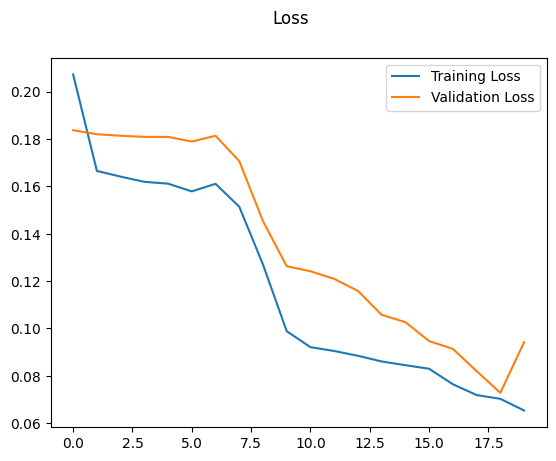

Result:

     Accuracy  F1 Score  Precision    Recall
251  0.975095  0.965099    0.97568  0.975095

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.82      0.87      0.84      1076
      Normal       0.98      1.00      0.99     74723
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77375
   macro avg       0.60      0.62      0.61     77375
weighted avg       0.96      0.98      0.97     77375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


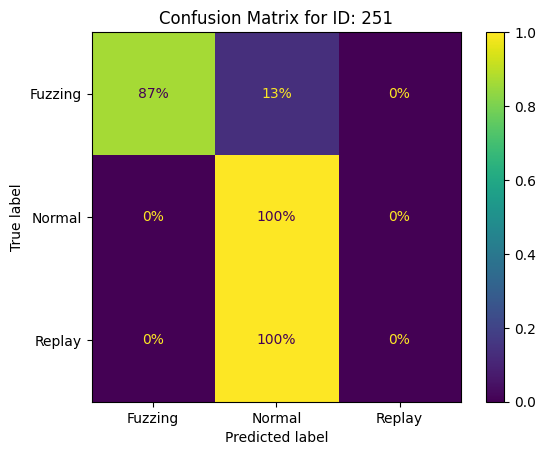

<Figure size 800x600 with 0 Axes>





Processing ID: 2B0
Epoch 1/20
362/362 [==============================] - 10s 15ms/step - loss: 0.2100 - accuracy: 0.9700 - val_loss: 0.1758 - val_accuracy: 0.9658
Epoch 2/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1647 - accuracy: 0.9720 - val_loss: 0.1739 - val_accuracy: 0.9658
Epoch 3/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1612 - accuracy: 0.9720 - val_loss: 0.1721 - val_accuracy: 0.9658
Epoch 4/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1598 - accuracy: 0.9720 - val_loss: 0.1707 - val_accuracy: 0.9658
Epoch 5/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1270 - accuracy: 0.9743 - val_loss: 0.1550 - val_accuracy: 0.9658
Epoch 6/20
362/362 [==============================] - 3s 9ms/step - loss: 0.0988 - accuracy: 0.9827 - val_loss: 0.1202 - val_accuracy: 0.9715
Epoch 7/20
362/362 [==============================] - 3s 9ms/step - loss: 0.0893 - accuracy: 0.9844 - val_loss: 0.0928 - v

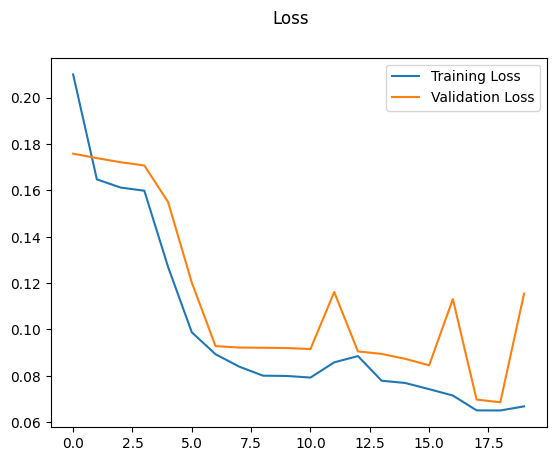

Result:

     Accuracy  F1 Score  Precision  Recall
2B0    0.9769  0.966705    0.95708  0.9769

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.80      0.89      1043
      Normal       0.98      1.00      0.99     74696
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77315
   macro avg       0.66      0.60      0.63     77315
weighted avg       0.96      0.98      0.97     77315



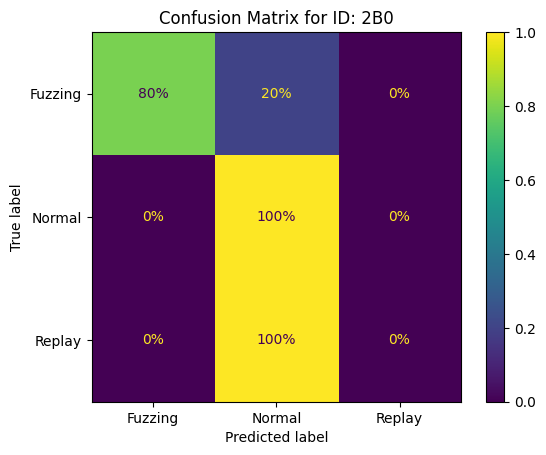

<Figure size 800x600 with 0 Axes>





Processing ID: 381
Epoch 1/20
181/181 [==============================] - 9s 16ms/step - loss: 0.2546 - accuracy: 0.9624 - val_loss: 0.1794 - val_accuracy: 0.9639
Epoch 2/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1690 - accuracy: 0.9718 - val_loss: 0.1786 - val_accuracy: 0.9639
Epoch 3/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1659 - accuracy: 0.9718 - val_loss: 0.1769 - val_accuracy: 0.9639
Epoch 4/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1530 - accuracy: 0.9733 - val_loss: 0.1114 - val_accuracy: 0.9794
Epoch 5/20
181/181 [==============================] - 3s 15ms/step - loss: 0.1182 - accuracy: 0.9782 - val_loss: 0.1078 - val_accuracy: 0.9794
Epoch 6/20
181/181 [==============================] - 2s 12ms/step - loss: 0.0984 - accuracy: 0.9836 - val_loss: 0.1048 - val_accuracy: 0.9793
Epoch 7/20
181/181 [==============================] - 2s 10ms/step - loss: 0.0843 - accuracy: 0.9860 - val_loss: 0.0970

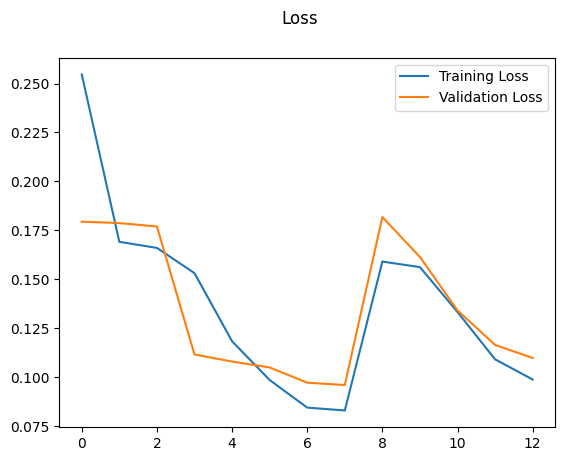

Result:

     Accuracy  F1 Score  Precision    Recall
381  0.976484  0.966228   0.977043  0.976484

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.77      0.87       523
      Normal       0.98      1.00      0.99     37344
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38655
   macro avg       0.66      0.59      0.62     38655
weighted avg       0.96      0.98      0.97     38655



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


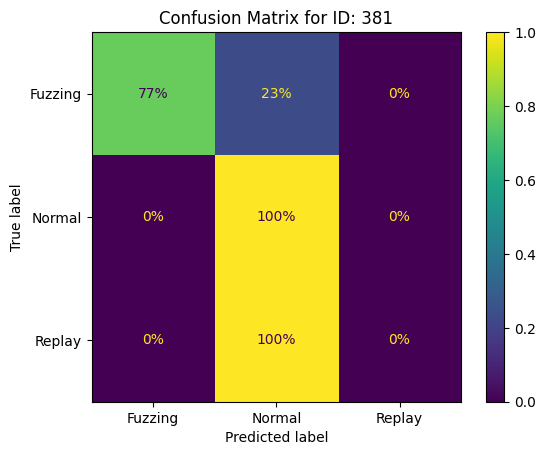

<Figure size 800x600 with 0 Axes>





Processing ID: 340
Epoch 1/20
360/360 [==============================] - 10s 14ms/step - loss: 0.1699 - accuracy: 0.9765 - val_loss: 0.1418 - val_accuracy: 0.9729
Epoch 2/20
360/360 [==============================] - 4s 12ms/step - loss: 0.1303 - accuracy: 0.9788 - val_loss: 0.1416 - val_accuracy: 0.9729
Epoch 3/20
360/360 [==============================] - 5s 13ms/step - loss: 0.1293 - accuracy: 0.9788 - val_loss: 0.1414 - val_accuracy: 0.9729
Epoch 4/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1277 - accuracy: 0.9788 - val_loss: 0.1413 - val_accuracy: 0.9729
Epoch 5/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1267 - accuracy: 0.9788 - val_loss: 0.1413 - val_accuracy: 0.9729
Epoch 6/20
360/360 [==============================] - 5s 14ms/step - loss: 0.1260 - accuracy: 0.9788 - val_loss: 0.1414 - val_accuracy: 0.9729
Epoch 7/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1242 - accuracy: 0.9788 - val_loss: 0.141

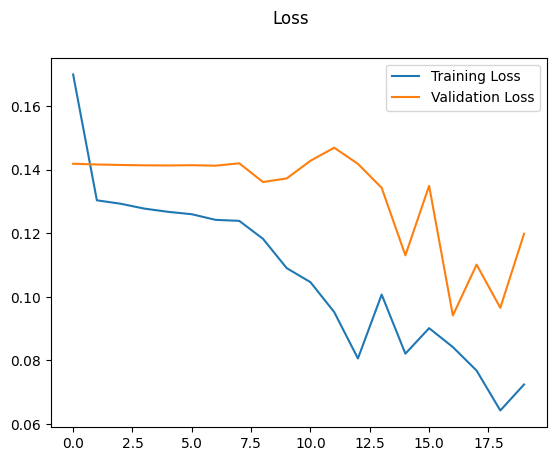

Result:

     Accuracy  F1 Score  Precision    Recall
340  0.973267  0.960419   0.973982  0.973267

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.06      0.11       506
      Normal       0.97      1.00      0.99     74679
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.97     76760
   macro avg       0.66      0.35      0.36     76760
weighted avg       0.95      0.97      0.96     76760



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


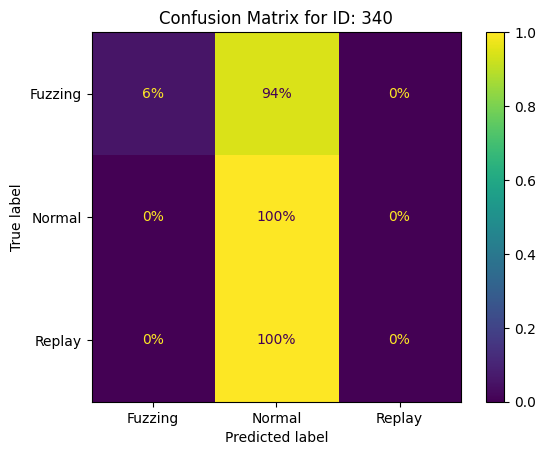

<Figure size 800x600 with 0 Axes>





Processing ID: 260
Epoch 1/20
362/362 [==============================] - 10s 13ms/step - loss: 0.2067 - accuracy: 0.9695 - val_loss: 0.1783 - val_accuracy: 0.9659
Epoch 2/20
362/362 [==============================] - 5s 15ms/step - loss: 0.1645 - accuracy: 0.9719 - val_loss: 0.1761 - val_accuracy: 0.9659
Epoch 3/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1615 - accuracy: 0.9719 - val_loss: 0.1750 - val_accuracy: 0.9659
Epoch 4/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1602 - accuracy: 0.9719 - val_loss: 0.1745 - val_accuracy: 0.9659
Epoch 5/20
362/362 [==============================] - 5s 13ms/step - loss: 0.1583 - accuracy: 0.9719 - val_loss: 0.1744 - val_accuracy: 0.9659
Epoch 6/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1561 - accuracy: 0.9719 - val_loss: 0.1746 - val_accuracy: 0.9659
Epoch 7/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1531 - accuracy: 0.9719 - val_loss: 0.174

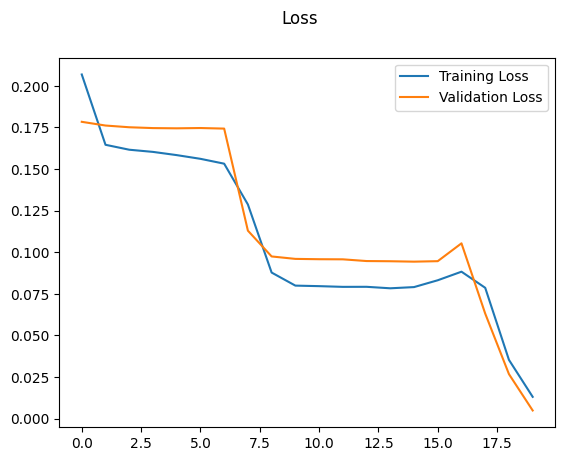

Result:

     Accuracy  F1 Score  Precision    Recall
260  0.996788  0.996696    0.99677  0.996788

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.99      0.86      0.92       970
      Normal       1.00      1.00      1.00     74673
      Replay       0.99      0.93      0.96      1577

    accuracy                           1.00     77220
   macro avg       0.99      0.93      0.96     77220
weighted avg       1.00      1.00      1.00     77220



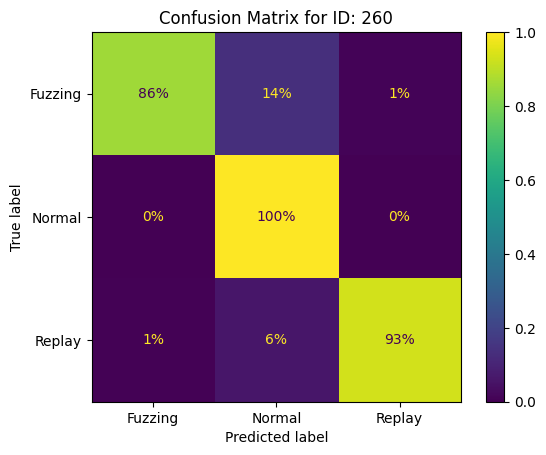

<Figure size 800x600 with 0 Axes>





Processing ID: 47F
Epoch 1/20
181/181 [==============================] - 9s 18ms/step - loss: 0.2625 - accuracy: 0.9677 - val_loss: 0.1852 - val_accuracy: 0.9625
Epoch 2/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1755 - accuracy: 0.9703 - val_loss: 0.1844 - val_accuracy: 0.9625
Epoch 3/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1710 - accuracy: 0.9703 - val_loss: 0.1836 - val_accuracy: 0.9625
Epoch 4/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1694 - accuracy: 0.9703 - val_loss: 0.1847 - val_accuracy: 0.9625
Epoch 5/20
181/181 [==============================] - 3s 14ms/step - loss: 0.1658 - accuracy: 0.9703 - val_loss: 0.1820 - val_accuracy: 0.9625
Epoch 6/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1686 - accuracy: 0.9703 - val_loss: 0.1849 - val_accuracy: 0.9625
Epoch 7/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1627 - accuracy: 0.9703 - val_loss: 0.1752

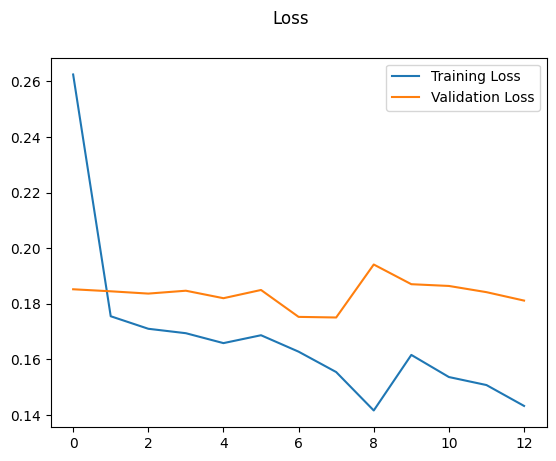

Result:

     Accuracy  F1 Score  Precision    Recall
47F  0.966541  0.950096    0.96766  0.966541

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       505
      Normal       0.97      1.00      0.98     37351
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38644
   macro avg       0.32      0.33      0.33     38644
weighted avg       0.93      0.97      0.95     38644



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


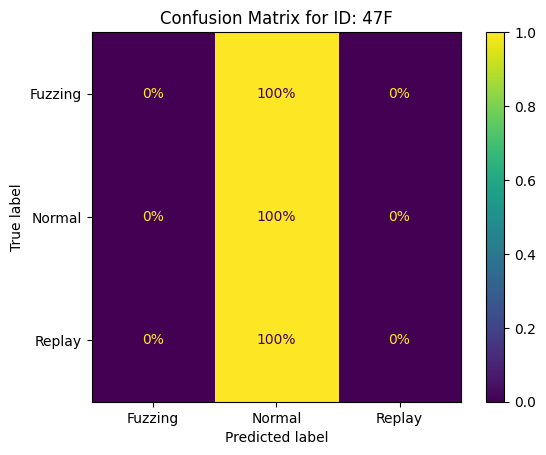

<Figure size 800x600 with 0 Axes>





Processing ID: 329
Epoch 1/20
360/360 [==============================] - 11s 15ms/step - loss: 0.1738 - accuracy: 0.9779 - val_loss: 0.1464 - val_accuracy: 0.9724
Epoch 2/20
360/360 [==============================] - 4s 10ms/step - loss: 0.1325 - accuracy: 0.9786 - val_loss: 0.1455 - val_accuracy: 0.9724
Epoch 3/20
360/360 [==============================] - 5s 15ms/step - loss: 0.1307 - accuracy: 0.9786 - val_loss: 0.1451 - val_accuracy: 0.9724
Epoch 4/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1291 - accuracy: 0.9786 - val_loss: 0.1447 - val_accuracy: 0.9724
Epoch 5/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1284 - accuracy: 0.9786 - val_loss: 0.1446 - val_accuracy: 0.9724
Epoch 6/20
360/360 [==============================] - 5s 14ms/step - loss: 0.1276 - accuracy: 0.9786 - val_loss: 0.1445 - val_accuracy: 0.9724
Epoch 7/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1258 - accuracy: 0.9786 - val_loss: 0.144

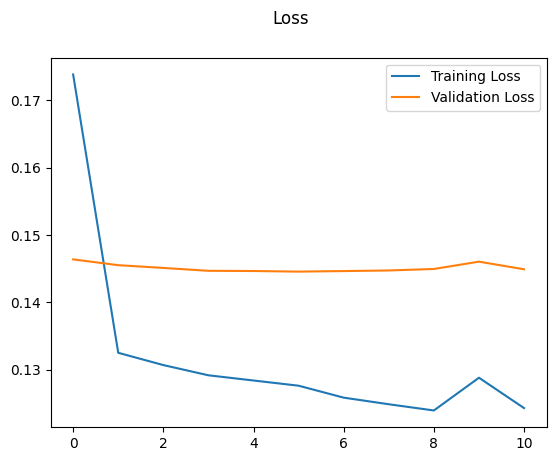

Result:

     Accuracy  F1 Score  Precision   Recall
329   0.97278  0.959357   0.973521  0.97278

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       512
      Normal       0.97      1.00      0.99     74655
      Replay       0.00      0.00      0.00      1577

    accuracy                           0.97     76744
   macro avg       0.32      0.33      0.33     76744
weighted avg       0.95      0.97      0.96     76744



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


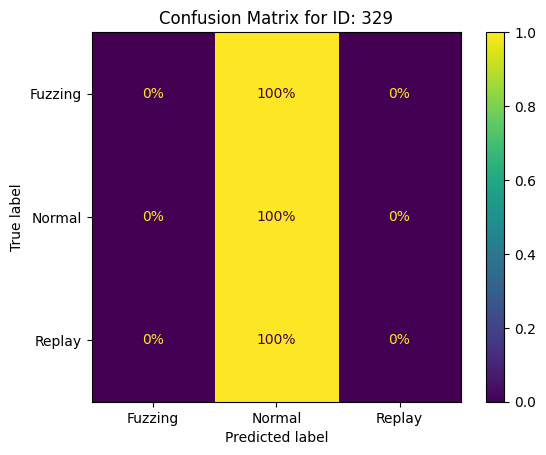

<Figure size 800x600 with 0 Axes>





Processing ID: 164
Epoch 1/20
362/362 [==============================] - 9s 13ms/step - loss: 0.2043 - accuracy: 0.9701 - val_loss: 0.1828 - val_accuracy: 0.9640
Epoch 2/20
362/362 [==============================] - 5s 13ms/step - loss: 0.1594 - accuracy: 0.9729 - val_loss: 0.1805 - val_accuracy: 0.9640
Epoch 3/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1569 - accuracy: 0.9729 - val_loss: 0.1785 - val_accuracy: 0.9640
Epoch 4/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1510 - accuracy: 0.9729 - val_loss: 0.1695 - val_accuracy: 0.9640
Epoch 5/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1317 - accuracy: 0.9729 - val_loss: 0.1357 - val_accuracy: 0.9640
Epoch 6/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1038 - accuracy: 0.9816 - val_loss: 0.0982 - val_accuracy: 0.9816
Epoch 7/20
362/362 [==============================] - 3s 9ms/step - loss: 0.0761 - accuracy: 0.9864 - val_loss: 0.1650 

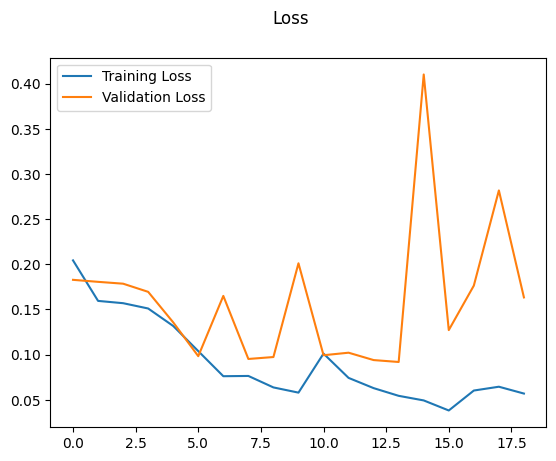

Result:

     Accuracy  F1 Score  Precision    Recall
164  0.976248  0.965953   0.976818  0.976248

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.75      0.85      1023
      Normal       0.98      1.00      0.99     74700
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77299
   macro avg       0.66      0.58      0.61     77299
weighted avg       0.96      0.98      0.97     77299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


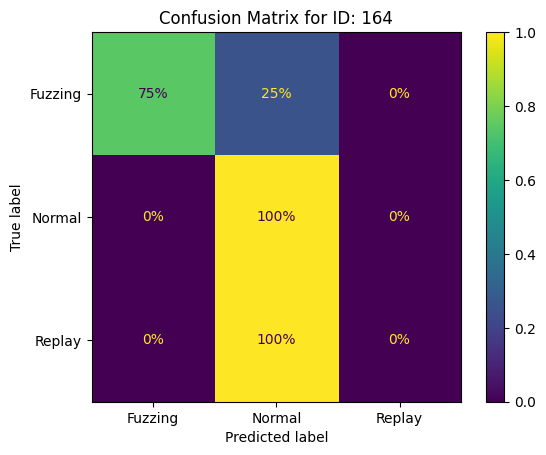

<Figure size 800x600 with 0 Axes>





Processing ID: 387
Epoch 1/20
182/182 [==============================] - 8s 21ms/step - loss: 0.2605 - accuracy: 0.9691 - val_loss: 0.1830 - val_accuracy: 0.9631
Epoch 2/20
182/182 [==============================] - 2s 11ms/step - loss: 0.1716 - accuracy: 0.9711 - val_loss: 0.1829 - val_accuracy: 0.9631
Epoch 3/20
182/182 [==============================] - 2s 10ms/step - loss: 0.1682 - accuracy: 0.9711 - val_loss: 0.1828 - val_accuracy: 0.9631
Epoch 4/20
182/182 [==============================] - 2s 10ms/step - loss: 0.1656 - accuracy: 0.9711 - val_loss: 0.1826 - val_accuracy: 0.9631
Epoch 5/20
182/182 [==============================] - 2s 10ms/step - loss: 0.1641 - accuracy: 0.9711 - val_loss: 0.1822 - val_accuracy: 0.9631
Epoch 6/20
182/182 [==============================] - 2s 10ms/step - loss: 0.1630 - accuracy: 0.9711 - val_loss: 0.1829 - val_accuracy: 0.9631
Epoch 7/20
182/182 [==============================] - 2s 12ms/step - loss: 0.1602 - accuracy: 0.9711 - val_loss: 0.1773

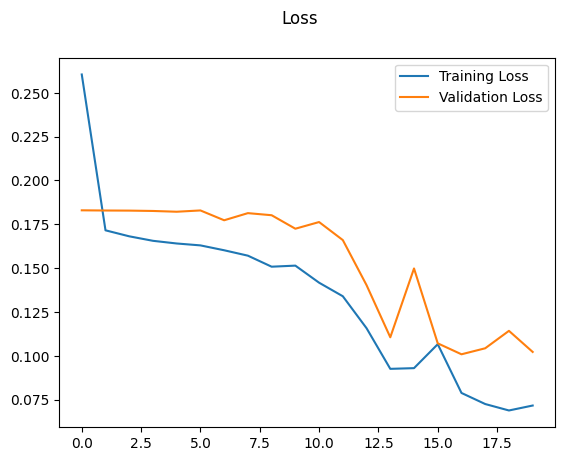

Result:

     Accuracy  F1 Score  Precision    Recall
387  0.970285  0.957813    0.97111  0.970285

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.99      0.30      0.46       512
      Normal       0.97      1.00      0.98     37300
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38600
   macro avg       0.65      0.43      0.48     38600
weighted avg       0.95      0.97      0.96     38600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


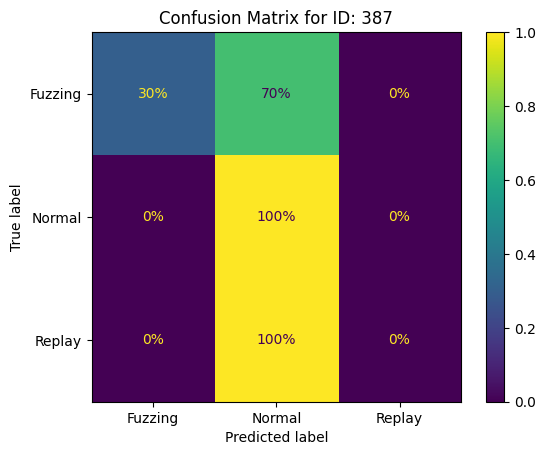

<Figure size 800x600 with 0 Axes>





Processing ID: 394
Epoch 1/20
181/181 [==============================] - 9s 19ms/step - loss: 0.2433 - accuracy: 0.9683 - val_loss: 0.1679 - val_accuracy: 0.9671
Epoch 2/20
181/181 [==============================] - 3s 17ms/step - loss: 0.1710 - accuracy: 0.9714 - val_loss: 0.1669 - val_accuracy: 0.9671
Epoch 3/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1672 - accuracy: 0.9714 - val_loss: 0.1652 - val_accuracy: 0.9671
Epoch 4/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1612 - accuracy: 0.9714 - val_loss: 0.1506 - val_accuracy: 0.9671
Epoch 5/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1201 - accuracy: 0.9748 - val_loss: 0.1049 - val_accuracy: 0.9760
Epoch 6/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1195 - accuracy: 0.9782 - val_loss: 0.1112 - val_accuracy: 0.9768
Epoch 7/20
181/181 [==============================] - 3s 14ms/step - loss: 0.1041 - accuracy: 0.9790 - val_loss: 0.1038

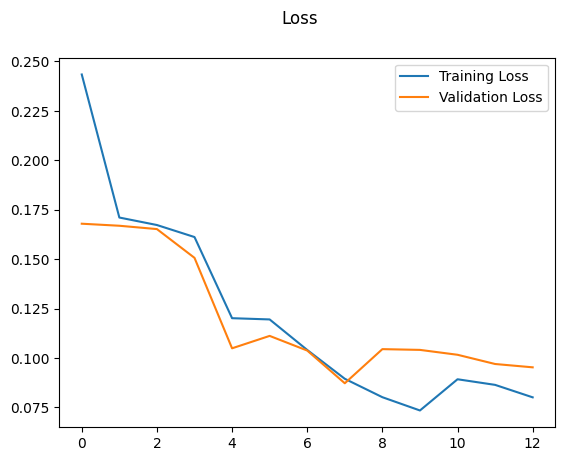

Result:

     Accuracy  F1 Score  Precision    Recall
394  0.979097  0.968986   0.979539  0.979097

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       452
      Normal       0.98      1.00      0.99     37319
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38559
   macro avg       0.66      0.65      0.66     38559
weighted avg       0.96      0.98      0.97     38559



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


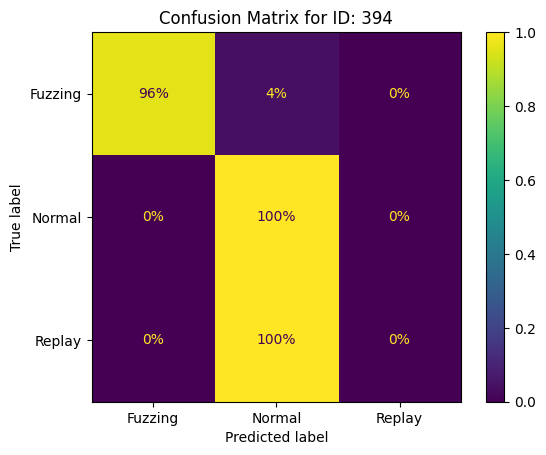

<Figure size 800x600 with 0 Axes>





Processing ID: 4F1
Epoch 1/20
181/181 [==============================] - 7s 17ms/step - loss: 0.2555 - accuracy: 0.9658 - val_loss: 0.1804 - val_accuracy: 0.9633
Epoch 2/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1702 - accuracy: 0.9718 - val_loss: 0.1759 - val_accuracy: 0.9633
Epoch 3/20
181/181 [==============================] - 2s 14ms/step - loss: 0.1591 - accuracy: 0.9718 - val_loss: 0.1905 - val_accuracy: 0.9611
Epoch 4/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1072 - accuracy: 0.9816 - val_loss: 0.0961 - val_accuracy: 0.9816
Epoch 5/20
181/181 [==============================] - 2s 10ms/step - loss: 0.0831 - accuracy: 0.9864 - val_loss: 0.0933 - val_accuracy: 0.9813
Epoch 6/20
181/181 [==============================] - 2s 11ms/step - loss: 0.0811 - accuracy: 0.9865 - val_loss: 0.0981 - val_accuracy: 0.9789
Epoch 7/20
181/181 [==============================] - 2s 10ms/step - loss: 0.0801 - accuracy: 0.9865 - val_loss: 0.0945

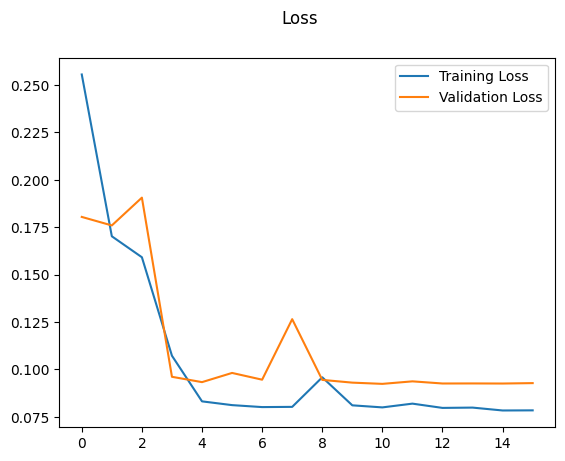

Result:

     Accuracy  F1 Score  Precision    Recall
4F1  0.978736   0.96862   0.979194  0.978736

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.97       482
      Normal       0.98      1.00      0.99     37293
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38563
   macro avg       0.66      0.64      0.65     38563
weighted avg       0.96      0.98      0.97     38563



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


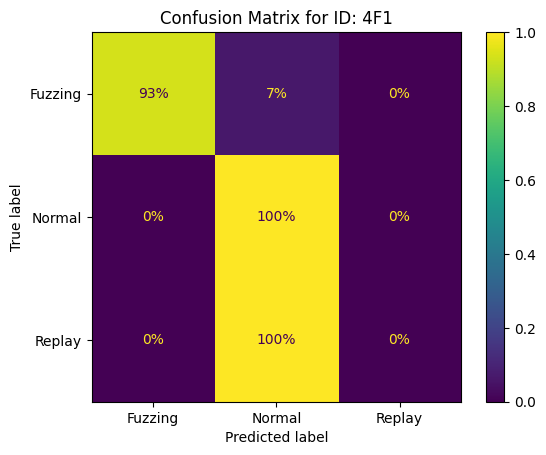

<Figure size 800x600 with 0 Axes>





Processing ID: 130
Epoch 1/20
362/362 [==============================] - 9s 12ms/step - loss: 0.2122 - accuracy: 0.9686 - val_loss: 0.1822 - val_accuracy: 0.9650
Epoch 2/20
362/362 [==============================] - 5s 13ms/step - loss: 0.1670 - accuracy: 0.9718 - val_loss: 0.1794 - val_accuracy: 0.9650
Epoch 3/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1642 - accuracy: 0.9718 - val_loss: 0.1781 - val_accuracy: 0.9650
Epoch 4/20
362/362 [==============================] - 3s 10ms/step - loss: 0.1621 - accuracy: 0.9718 - val_loss: 0.1777 - val_accuracy: 0.9650
Epoch 5/20
362/362 [==============================] - 3s 9ms/step - loss: 0.1601 - accuracy: 0.9718 - val_loss: 0.1775 - val_accuracy: 0.9650
Epoch 6/20
362/362 [==============================] - 5s 13ms/step - loss: 0.1577 - accuracy: 0.9718 - val_loss: 0.1776 - val_accuracy: 0.9650
Epoch 7/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1548 - accuracy: 0.9718 - val_loss: 0.1779 

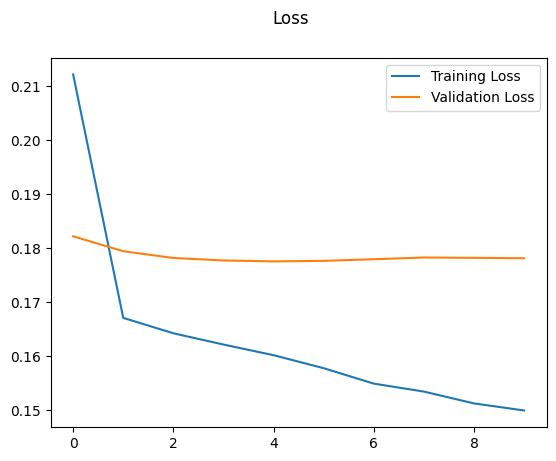

Result:

     Accuracy  F1 Score  Precision    Recall
130  0.966309  0.949751   0.967444  0.966309

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00      1028
      Normal       0.97      1.00      0.98     74657
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.97     77260
   macro avg       0.32      0.33      0.33     77260
weighted avg       0.93      0.97      0.95     77260



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


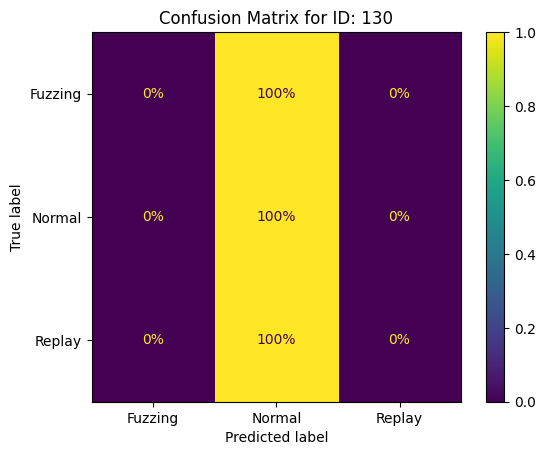

<Figure size 800x600 with 0 Axes>





Processing ID: 140
Epoch 1/20
362/362 [==============================] - 10s 15ms/step - loss: 0.2146 - accuracy: 0.9675 - val_loss: 0.1812 - val_accuracy: 0.9642
Epoch 2/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1666 - accuracy: 0.9719 - val_loss: 0.1804 - val_accuracy: 0.9642
Epoch 3/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1631 - accuracy: 0.9719 - val_loss: 0.1798 - val_accuracy: 0.9642
Epoch 4/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1606 - accuracy: 0.9719 - val_loss: 0.1796 - val_accuracy: 0.9642
Epoch 5/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1587 - accuracy: 0.9719 - val_loss: 0.1796 - val_accuracy: 0.9642
Epoch 6/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1570 - accuracy: 0.9719 - val_loss: 0.1797 - val_accuracy: 0.9642
Epoch 7/20
362/362 [==============================] - 4s 10ms/step - loss: 0.1547 - accuracy: 0.9719 - val_loss: 0.179

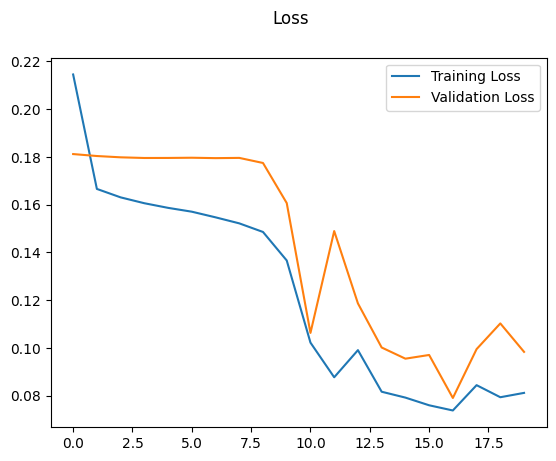

Result:

     Accuracy  F1 Score  Precision    Recall
140  0.972354   0.96095   0.973123  0.972354

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.44      0.61      1004
      Normal       0.97      1.00      0.99     74648
      Replay       0.00      0.00      0.00      1575

    accuracy                           0.97     77227
   macro avg       0.66      0.48      0.53     77227
weighted avg       0.95      0.97      0.96     77227



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


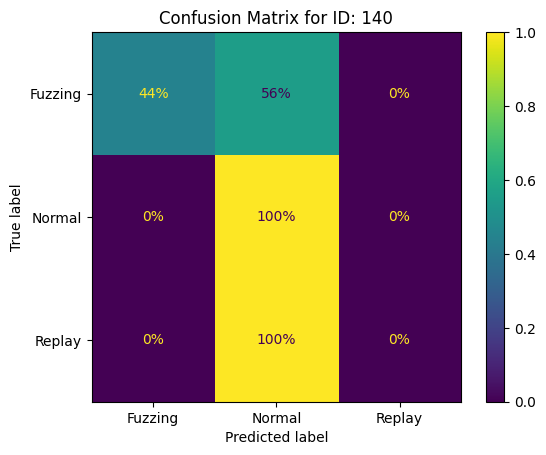

<Figure size 800x600 with 0 Axes>





Processing ID: 356
Epoch 1/20
360/360 [==============================] - 9s 12ms/step - loss: 0.1701 - accuracy: 0.9784 - val_loss: 0.1416 - val_accuracy: 0.9733
Epoch 2/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1280 - accuracy: 0.9792 - val_loss: 0.1406 - val_accuracy: 0.9733
Epoch 3/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1264 - accuracy: 0.9792 - val_loss: 0.1402 - val_accuracy: 0.9733
Epoch 4/20
360/360 [==============================] - 3s 10ms/step - loss: 0.1249 - accuracy: 0.9792 - val_loss: 0.1399 - val_accuracy: 0.9733
Epoch 5/20
360/360 [==============================] - 3s 9ms/step - loss: 0.1234 - accuracy: 0.9792 - val_loss: 0.1396 - val_accuracy: 0.9733
Epoch 6/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1216 - accuracy: 0.9792 - val_loss: 0.1390 - val_accuracy: 0.9733
Epoch 7/20
360/360 [==============================] - 4s 11ms/step - loss: 0.1189 - accuracy: 0.9792 - val_loss: 0.1378 

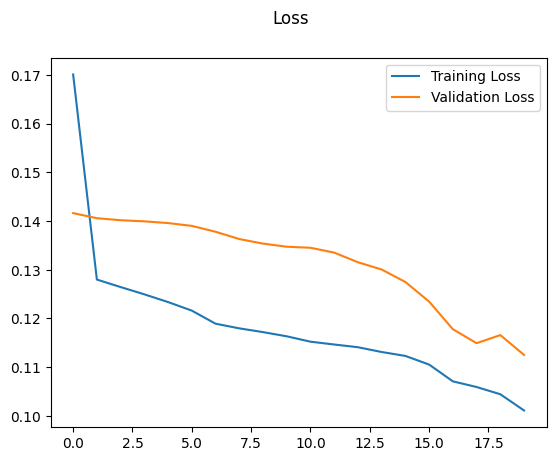

Result:

     Accuracy  F1 Score  Precision    Recall
356  0.972648  0.959162   0.973396  0.972648

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       526
      Normal       0.97      1.00      0.99     74749
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.97     76851
   macro avg       0.32      0.33      0.33     76851
weighted avg       0.95      0.97      0.96     76851



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


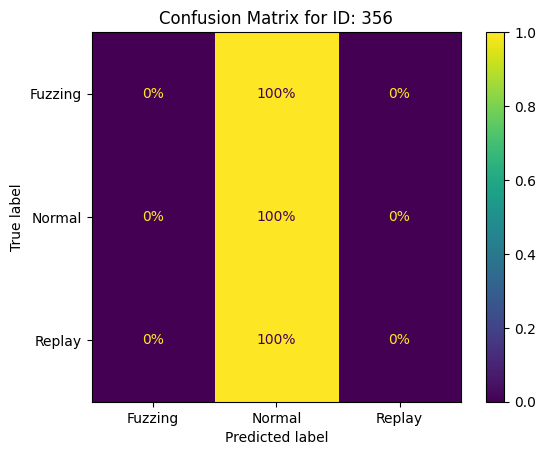

<Figure size 800x600 with 0 Axes>





Processing ID: 153
Epoch 1/20
362/362 [==============================] - 10s 16ms/step - loss: 0.2046 - accuracy: 0.9706 - val_loss: 0.1840 - val_accuracy: 0.9644
Epoch 2/20
362/362 [==============================] - 5s 15ms/step - loss: 0.1620 - accuracy: 0.9719 - val_loss: 0.1680 - val_accuracy: 0.9644
Epoch 3/20
362/362 [==============================] - 4s 12ms/step - loss: 0.1180 - accuracy: 0.9736 - val_loss: 0.1170 - val_accuracy: 0.9769
Epoch 4/20
362/362 [==============================] - 5s 14ms/step - loss: 0.0965 - accuracy: 0.9847 - val_loss: 0.1018 - val_accuracy: 0.9798
Epoch 5/20
362/362 [==============================] - 5s 14ms/step - loss: 0.0898 - accuracy: 0.9855 - val_loss: 0.1013 - val_accuracy: 0.9798
Epoch 6/20
362/362 [==============================] - 5s 12ms/step - loss: 0.1217 - accuracy: 0.9705 - val_loss: 0.1104 - val_accuracy: 0.9784
Epoch 7/20
362/362 [==============================] - 5s 14ms/step - loss: 0.0955 - accuracy: 0.9846 - val_loss: 0.109

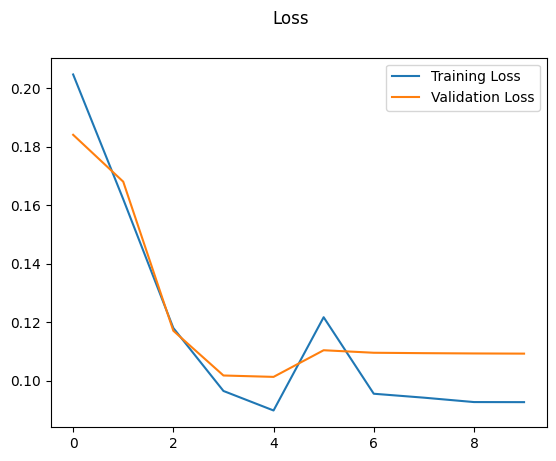

Result:

     Accuracy  F1 Score  Precision    Recall
153  0.979434  0.969336   0.979862  0.979434

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       980
      Normal       0.98      1.00      0.99     74658
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.98     77214
   macro avg       0.66      0.66      0.66     77214
weighted avg       0.96      0.98      0.97     77214



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


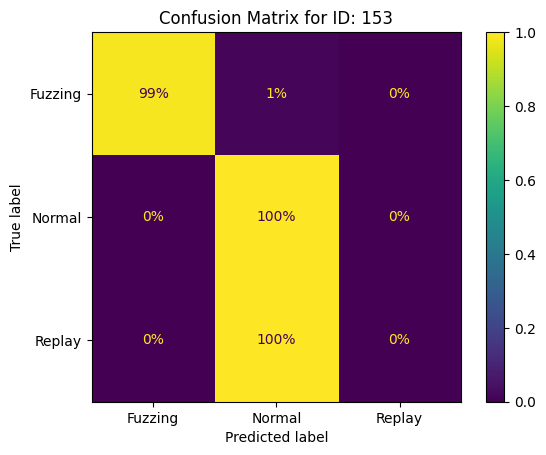

<Figure size 800x600 with 0 Axes>





Processing ID: 220
Epoch 1/20
363/363 [==============================] - 11s 14ms/step - loss: 0.2086 - accuracy: 0.9706 - val_loss: 0.1893 - val_accuracy: 0.9634
Epoch 2/20
363/363 [==============================] - 6s 16ms/step - loss: 0.1659 - accuracy: 0.9716 - val_loss: 0.1850 - val_accuracy: 0.9634
Epoch 3/20
363/363 [==============================] - 4s 11ms/step - loss: 0.1635 - accuracy: 0.9716 - val_loss: 0.1835 - val_accuracy: 0.9634
Epoch 4/20
363/363 [==============================] - 4s 11ms/step - loss: 0.1674 - accuracy: 0.9711 - val_loss: 0.1867 - val_accuracy: 0.9634
Epoch 5/20
363/363 [==============================] - 4s 12ms/step - loss: 0.1590 - accuracy: 0.9704 - val_loss: 0.1840 - val_accuracy: 0.9634
Epoch 6/20
363/363 [==============================] - 5s 13ms/step - loss: 0.1616 - accuracy: 0.9716 - val_loss: 0.1830 - val_accuracy: 0.9634
Epoch 7/20
363/363 [==============================] - 4s 11ms/step - loss: 0.1604 - accuracy: 0.9716 - val_loss: 0.182

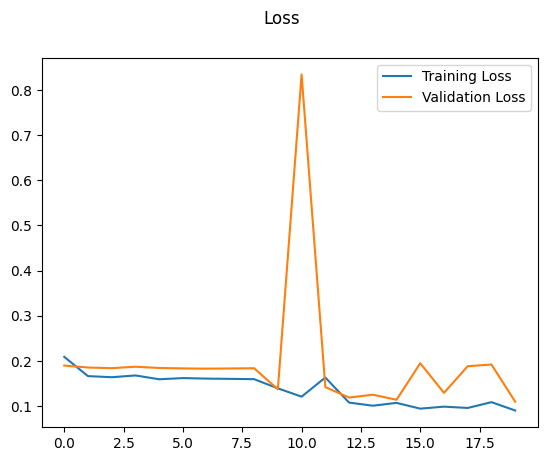

Result:

     Accuracy  F1 Score  Precision    Recall
220  0.966519  0.956821   0.967745  0.966519

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.50      0.56      0.53      1014
      Normal       0.97      0.99      0.98     74647
      Replay       0.00      0.00      0.00      1576

    accuracy                           0.97     77237
   macro avg       0.49      0.52      0.50     77237
weighted avg       0.95      0.97      0.96     77237



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


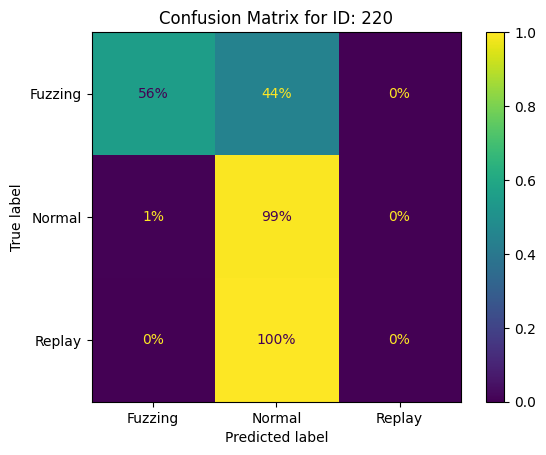

<Figure size 800x600 with 0 Axes>





Processing ID: 367
Epoch 1/20
359/359 [==============================] - 11s 18ms/step - loss: 0.1717 - accuracy: 0.9762 - val_loss: 0.1463 - val_accuracy: 0.9722
Epoch 2/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1304 - accuracy: 0.9790 - val_loss: 0.1457 - val_accuracy: 0.9722
Epoch 3/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1279 - accuracy: 0.9790 - val_loss: 0.1453 - val_accuracy: 0.9722
Epoch 4/20
359/359 [==============================] - 5s 15ms/step - loss: 0.1263 - accuracy: 0.9790 - val_loss: 0.1450 - val_accuracy: 0.9722
Epoch 5/20
359/359 [==============================] - 4s 12ms/step - loss: 0.1257 - accuracy: 0.9790 - val_loss: 0.1507 - val_accuracy: 0.9722
Epoch 6/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1247 - accuracy: 0.9790 - val_loss: 0.1458 - val_accuracy: 0.9722
Epoch 7/20
359/359 [==============================] - 5s 14ms/step - loss: 0.1231 - accuracy: 0.9790 - val_loss: 0.145

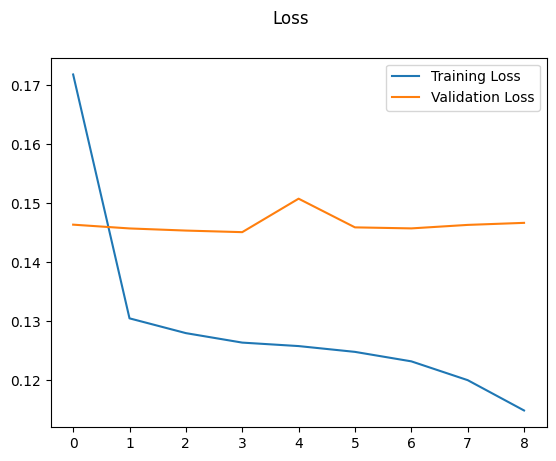

Result:

     Accuracy  F1 Score  Precision    Recall
367  0.972815   0.95941   0.973554  0.972815

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       503
      Normal       0.97      1.00      0.99     74684
      Replay       0.00      0.00      0.00      1584

    accuracy                           0.97     76771
   macro avg       0.32      0.33      0.33     76771
weighted avg       0.95      0.97      0.96     76771



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


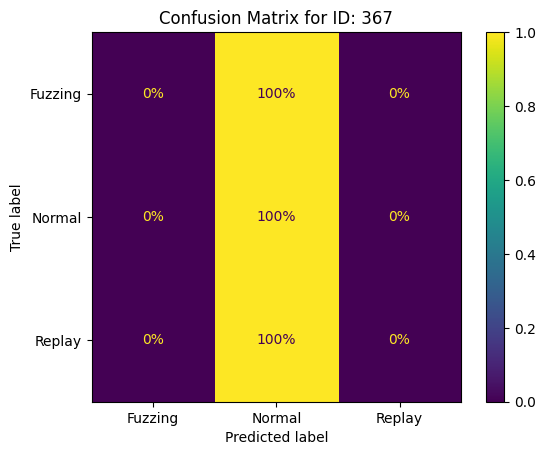

<Figure size 800x600 with 0 Axes>





Processing ID: 368
Epoch 1/20
359/359 [==============================] - 10s 16ms/step - loss: 0.1722 - accuracy: 0.9782 - val_loss: 0.1496 - val_accuracy: 0.9724
Epoch 2/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1325 - accuracy: 0.9784 - val_loss: 0.1457 - val_accuracy: 0.9724
Epoch 3/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1268 - accuracy: 0.9784 - val_loss: 0.1487 - val_accuracy: 0.9724
Epoch 4/20
359/359 [==============================] - 5s 14ms/step - loss: 0.1116 - accuracy: 0.9784 - val_loss: 0.1510 - val_accuracy: 0.9724
Epoch 5/20
359/359 [==============================] - 4s 12ms/step - loss: 0.1054 - accuracy: 0.9784 - val_loss: 0.1461 - val_accuracy: 0.9724
Epoch 6/20
359/359 [==============================] - 4s 10ms/step - loss: 0.1048 - accuracy: 0.9784 - val_loss: 0.1560 - val_accuracy: 0.9724
Epoch 7/20
359/359 [==============================] - 4s 11ms/step - loss: 0.1019 - accuracy: 0.9784 - val_loss: 0.144

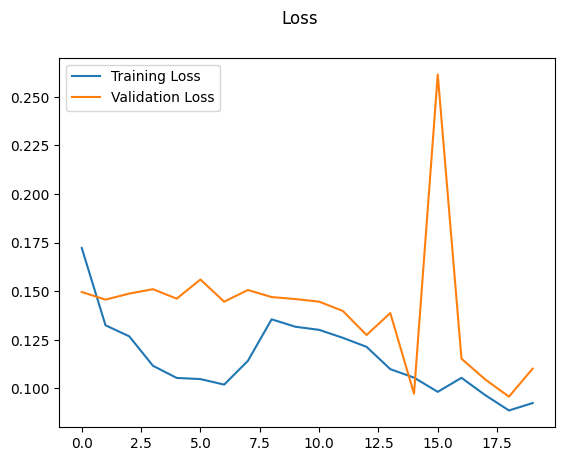

Result:

     Accuracy  F1 Score  Precision    Recall
368  0.974081  0.961857   0.974753  0.974081

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.12      0.21       466
      Normal       0.97      1.00      0.99     74657
      Replay       0.00      0.00      0.00      1577

    accuracy                           0.97     76700
   macro avg       0.66      0.37      0.40     76700
weighted avg       0.95      0.97      0.96     76700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


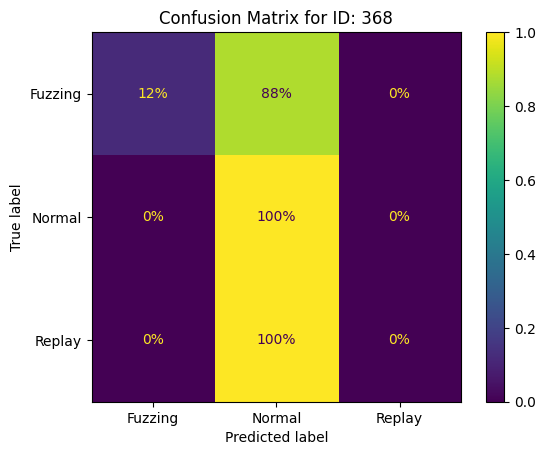

<Figure size 800x600 with 0 Axes>





Processing ID: 412
Epoch 1/20
21/21 [==============================] - 7s 64ms/step - loss: 0.7525 - accuracy: 0.8099 - val_loss: 0.5821 - val_accuracy: 0.8265
Epoch 2/20
21/21 [==============================] - 0s 13ms/step - loss: 0.4714 - accuracy: 0.8668 - val_loss: 0.4847 - val_accuracy: 0.8265
Epoch 3/20
21/21 [==============================] - 0s 14ms/step - loss: 0.4068 - accuracy: 0.8668 - val_loss: 0.3951 - val_accuracy: 0.8265
Epoch 4/20
21/21 [==============================] - 0s 12ms/step - loss: 0.2608 - accuracy: 0.9237 - val_loss: 0.1562 - val_accuracy: 0.9778
Epoch 5/20
21/21 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9855 - val_loss: 0.1021 - val_accuracy: 0.9831
Epoch 6/20
21/21 [==============================] - 0s 14ms/step - loss: 0.0769 - accuracy: 0.9874 - val_loss: 0.0927 - val_accuracy: 0.9831
Epoch 7/20
21/21 [==============================] - 0s 12ms/step - loss: 0.0729 - accuracy: 0.9878 - val_loss: 0.0900 - val_accurac

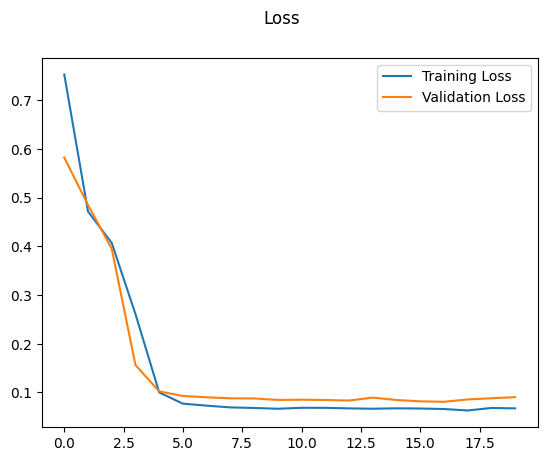

Result:

     Accuracy  F1 Score  Precision    Recall
412  0.980787  0.971747   0.981205  0.980787

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       511
      Normal       0.98      1.00      0.99      3730
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4320
   macro avg       0.66      0.66      0.66      4320
weighted avg       0.96      0.98      0.97      4320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


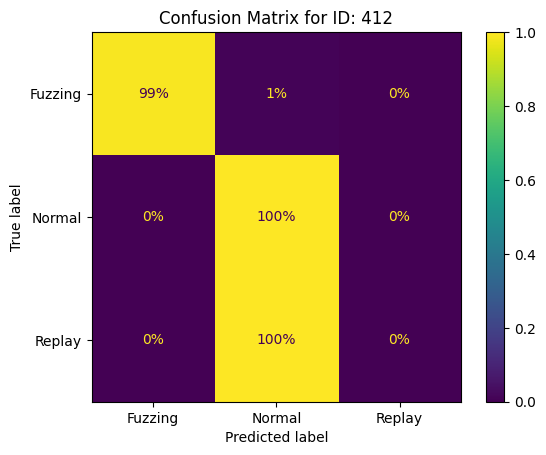

<Figure size 800x600 with 0 Axes>





Processing ID: 470
Epoch 1/20
181/181 [==============================] - 8s 21ms/step - loss: 0.2701 - accuracy: 0.9685 - val_loss: 0.1750 - val_accuracy: 0.9660
Epoch 2/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1745 - accuracy: 0.9707 - val_loss: 0.1734 - val_accuracy: 0.9660
Epoch 3/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1701 - accuracy: 0.9707 - val_loss: 0.1731 - val_accuracy: 0.9660
Epoch 4/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1695 - accuracy: 0.9707 - val_loss: 0.1729 - val_accuracy: 0.9660
Epoch 5/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1653 - accuracy: 0.9707 - val_loss: 0.1727 - val_accuracy: 0.9660
Epoch 6/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1642 - accuracy: 0.9707 - val_loss: 0.1727 - val_accuracy: 0.9660
Epoch 7/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1631 - accuracy: 0.9707 - val_loss: 0.1728

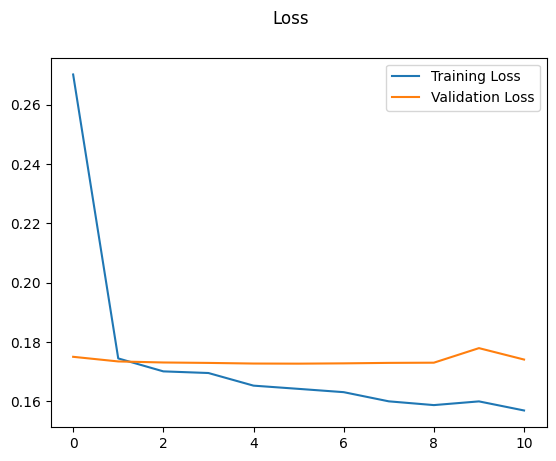

Result:

     Accuracy  F1 Score  Precision    Recall
470  0.966281   0.94971   0.967418  0.966281

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       511
      Normal       0.97      1.00      0.98     37225
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38524
   macro avg       0.32      0.33      0.33     38524
weighted avg       0.93      0.97      0.95     38524



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


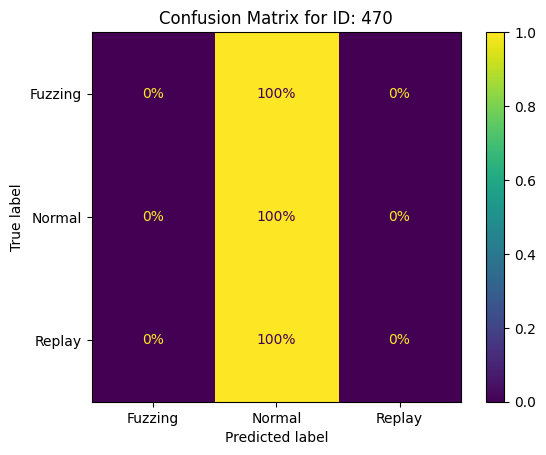

<Figure size 800x600 with 0 Axes>





Processing ID: 38D
Epoch 1/20
181/181 [==============================] - 9s 24ms/step - loss: 0.2442 - accuracy: 0.9715 - val_loss: 0.1753 - val_accuracy: 0.9650
Epoch 2/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1686 - accuracy: 0.9726 - val_loss: 0.1749 - val_accuracy: 0.9650
Epoch 3/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1627 - accuracy: 0.9726 - val_loss: 0.1741 - val_accuracy: 0.9650
Epoch 4/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1584 - accuracy: 0.9726 - val_loss: 0.1707 - val_accuracy: 0.9650
Epoch 5/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1446 - accuracy: 0.9747 - val_loss: 0.3096 - val_accuracy: 0.9255
Epoch 6/20
181/181 [==============================] - 3s 14ms/step - loss: 0.1143 - accuracy: 0.9803 - val_loss: 0.1614 - val_accuracy: 0.9673
Epoch 7/20
181/181 [==============================] - 3s 16ms/step - loss: 0.1491 - accuracy: 0.9732 - val_loss: 0.1344

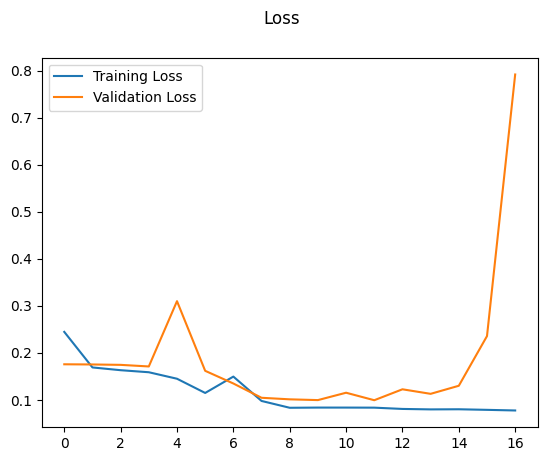

Result:

     Accuracy  F1 Score  Precision    Recall
38D  0.974182  0.963437   0.974854  0.974182

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.58      0.74       501
      Normal       0.97      1.00      0.99     37328
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38617
   macro avg       0.66      0.53      0.57     38617
weighted avg       0.95      0.97      0.96     38617



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


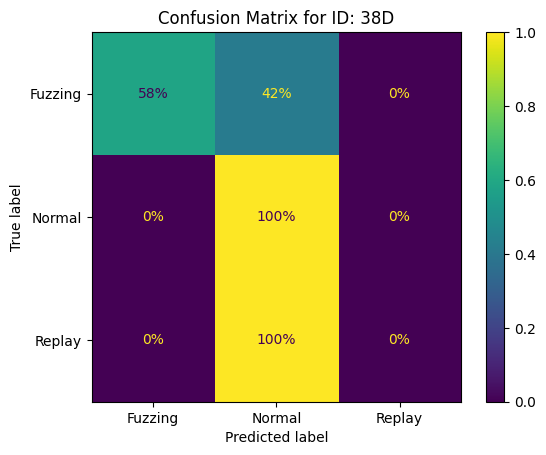

<Figure size 800x600 with 0 Axes>





Processing ID: 420
Epoch 1/20
181/181 [==============================] - 9s 23ms/step - loss: 0.2508 - accuracy: 0.9688 - val_loss: 0.1737 - val_accuracy: 0.9655
Epoch 2/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1677 - accuracy: 0.9721 - val_loss: 0.1735 - val_accuracy: 0.9655
Epoch 3/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1641 - accuracy: 0.9721 - val_loss: 0.1732 - val_accuracy: 0.9655
Epoch 4/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1612 - accuracy: 0.9721 - val_loss: 0.1720 - val_accuracy: 0.9655
Epoch 5/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1609 - accuracy: 0.9721 - val_loss: 0.1707 - val_accuracy: 0.9655
Epoch 6/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1589 - accuracy: 0.9721 - val_loss: 0.1708 - val_accuracy: 0.9655
Epoch 7/20
181/181 [==============================] - 3s 16ms/step - loss: 0.1483 - accuracy: 0.9721 - val_loss: 0.1658

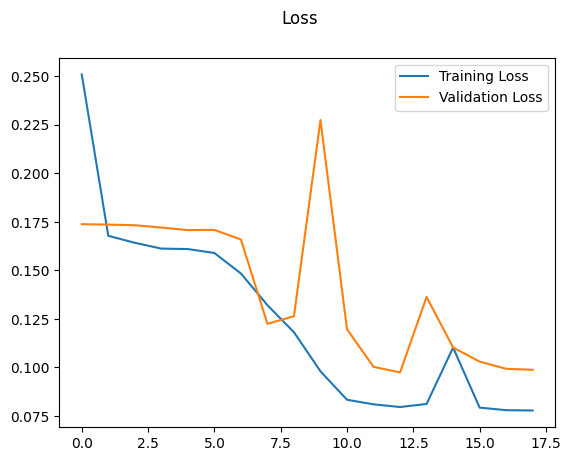

Result:

     Accuracy  F1 Score  Precision    Recall
420  0.979114  0.969011   0.979556  0.979114

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       501
      Normal       0.98      1.00      0.99     37301
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38590
   macro avg       0.66      0.65      0.66     38590
weighted avg       0.96      0.98      0.97     38590



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


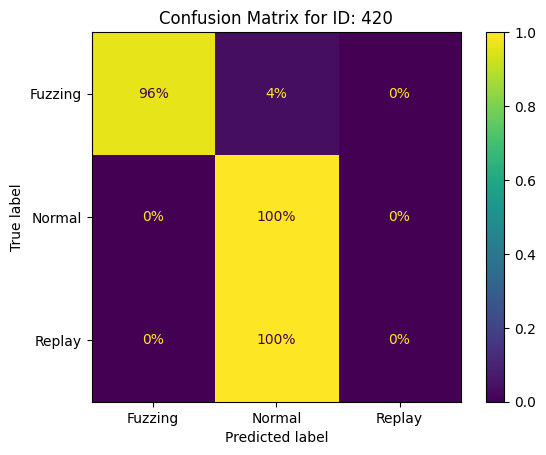

<Figure size 800x600 with 0 Axes>





Processing ID: 421
Epoch 1/20
181/181 [==============================] - 11s 23ms/step - loss: 0.2491 - accuracy: 0.9679 - val_loss: 0.1825 - val_accuracy: 0.9633
Epoch 2/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1693 - accuracy: 0.9713 - val_loss: 0.1825 - val_accuracy: 0.9633
Epoch 3/20
181/181 [==============================] - 2s 13ms/step - loss: 0.1669 - accuracy: 0.9713 - val_loss: 0.1825 - val_accuracy: 0.9633
Epoch 4/20
181/181 [==============================] - 2s 12ms/step - loss: 0.1641 - accuracy: 0.9713 - val_loss: 0.1825 - val_accuracy: 0.9633
Epoch 5/20
181/181 [==============================] - 3s 14ms/step - loss: 0.1624 - accuracy: 0.9713 - val_loss: 0.1824 - val_accuracy: 0.9633
Epoch 6/20
181/181 [==============================] - 3s 19ms/step - loss: 0.1608 - accuracy: 0.9713 - val_loss: 0.1820 - val_accuracy: 0.9633
Epoch 7/20
181/181 [==============================] - 2s 14ms/step - loss: 0.1585 - accuracy: 0.9713 - val_loss: 0.181

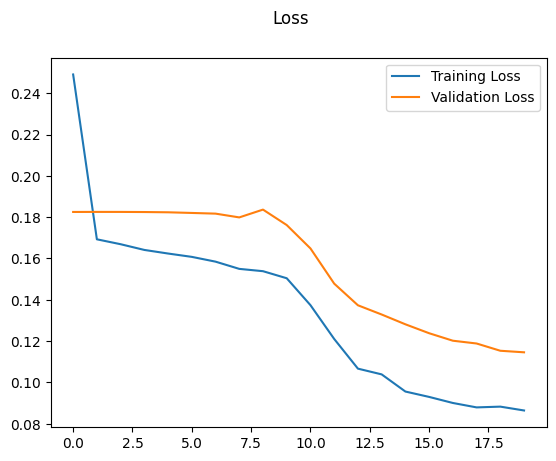

Result:

     Accuracy  F1 Score  Precision    Recall
421  0.975161  0.964651   0.975784  0.975161

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.66      0.79       499
      Normal       0.97      1.00      0.99     37282
      Replay       0.00      0.00      0.00       788

    accuracy                           0.98     38569
   macro avg       0.66      0.55      0.59     38569
weighted avg       0.96      0.98      0.96     38569



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


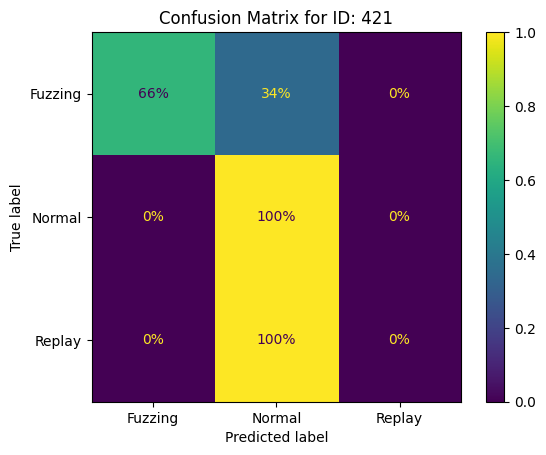

<Figure size 800x600 with 0 Axes>





Processing ID: 389
Epoch 1/20
181/181 [==============================] - 8s 21ms/step - loss: 0.2495 - accuracy: 0.9710 - val_loss: 0.1810 - val_accuracy: 0.9635
Epoch 2/20
181/181 [==============================] - 3s 15ms/step - loss: 0.1686 - accuracy: 0.9719 - val_loss: 0.1791 - val_accuracy: 0.9635
Epoch 3/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1627 - accuracy: 0.9719 - val_loss: 0.1755 - val_accuracy: 0.9635
Epoch 4/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1527 - accuracy: 0.9719 - val_loss: 0.1753 - val_accuracy: 0.9634
Epoch 5/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1098 - accuracy: 0.9774 - val_loss: 0.0966 - val_accuracy: 0.9808
Epoch 6/20
181/181 [==============================] - 2s 11ms/step - loss: 0.0897 - accuracy: 0.9852 - val_loss: 0.0929 - val_accuracy: 0.9816
Epoch 7/20
181/181 [==============================] - 2s 11ms/step - loss: 0.0807 - accuracy: 0.9864 - val_loss: 0.0925

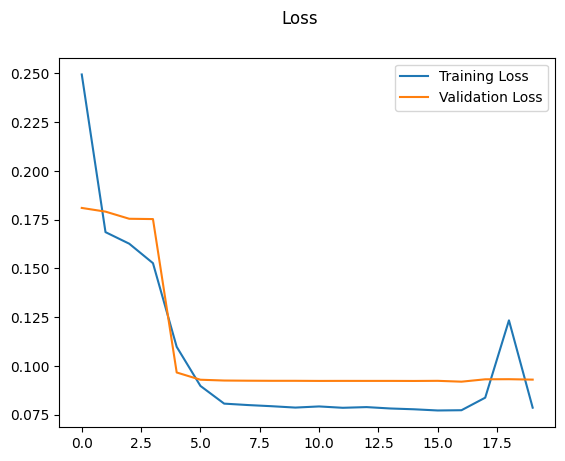

Result:

     Accuracy  F1 Score  Precision    Recall
389  0.979586  0.969486   0.980008  0.979586

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       493
      Normal       0.98      1.00      0.99     37272
      Replay       0.00      0.00      0.00       787

    accuracy                           0.98     38552
   macro avg       0.66      0.67      0.66     38552
weighted avg       0.96      0.98      0.97     38552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


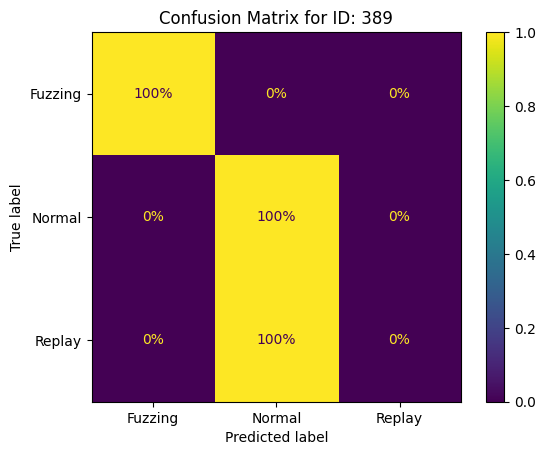

<Figure size 800x600 with 0 Axes>





Processing ID: 386
Epoch 1/20
181/181 [==============================] - 8s 20ms/step - loss: 0.2659 - accuracy: 0.9703 - val_loss: 0.1711 - val_accuracy: 0.9662
Epoch 2/20
181/181 [==============================] - 2s 14ms/step - loss: 0.1729 - accuracy: 0.9706 - val_loss: 0.1708 - val_accuracy: 0.9662
Epoch 3/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1695 - accuracy: 0.9706 - val_loss: 0.1705 - val_accuracy: 0.9662
Epoch 4/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1673 - accuracy: 0.9706 - val_loss: 0.1698 - val_accuracy: 0.9662
Epoch 5/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1664 - accuracy: 0.9706 - val_loss: 0.1697 - val_accuracy: 0.9662
Epoch 6/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1623 - accuracy: 0.9698 - val_loss: 0.1730 - val_accuracy: 0.9662
Epoch 7/20
181/181 [==============================] - 2s 11ms/step - loss: 0.1607 - accuracy: 0.9706 - val_loss: 0.1622

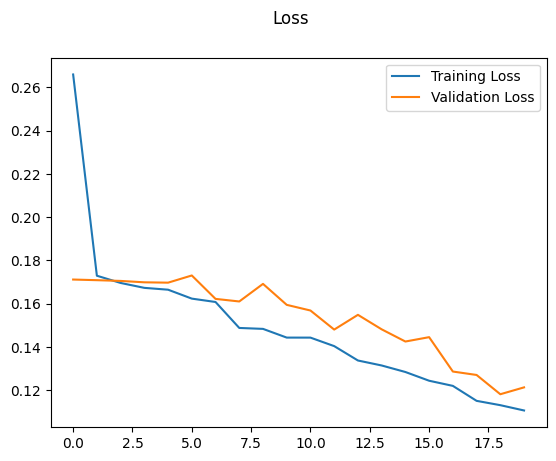

Result:

     Accuracy  F1 Score  Precision    Recall
386  0.973321   0.96231   0.974038  0.973321

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.52      0.68       505
      Normal       0.97      1.00      0.99     37314
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38607
   macro avg       0.66      0.51      0.56     38607
weighted avg       0.95      0.97      0.96     38607



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


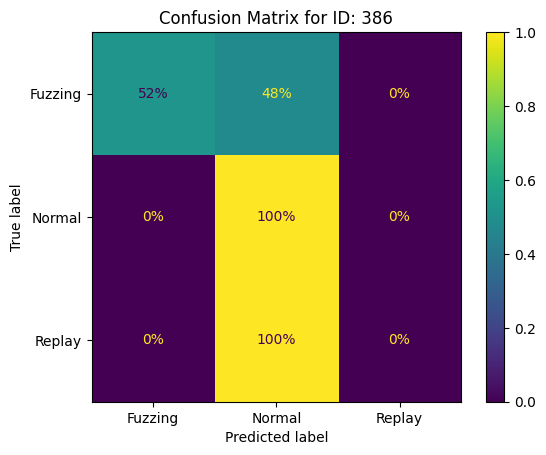

<Figure size 800x600 with 0 Axes>





Processing ID: 492
Epoch 1/20
74/74 [==============================] - 6s 26ms/step - loss: 0.4020 - accuracy: 0.9425 - val_loss: 0.2714 - val_accuracy: 0.9391
Epoch 2/20
74/74 [==============================] - 1s 12ms/step - loss: 0.2403 - accuracy: 0.9518 - val_loss: 0.2641 - val_accuracy: 0.9391
Epoch 3/20
74/74 [==============================] - 1s 12ms/step - loss: 0.2351 - accuracy: 0.9518 - val_loss: 0.2542 - val_accuracy: 0.9391
Epoch 4/20
74/74 [==============================] - 1s 13ms/step - loss: 0.2231 - accuracy: 0.9518 - val_loss: 0.2030 - val_accuracy: 0.9391
Epoch 5/20
74/74 [==============================] - 1s 15ms/step - loss: 0.1794 - accuracy: 0.9588 - val_loss: 0.1320 - val_accuracy: 0.9783
Epoch 6/20
74/74 [==============================] - 1s 14ms/step - loss: 0.0931 - accuracy: 0.9844 - val_loss: 0.1051 - val_accuracy: 0.9810
Epoch 7/20
74/74 [==============================] - 1s 16ms/step - loss: 0.0832 - accuracy: 0.9853 - val_loss: 0.0943 - val_accurac

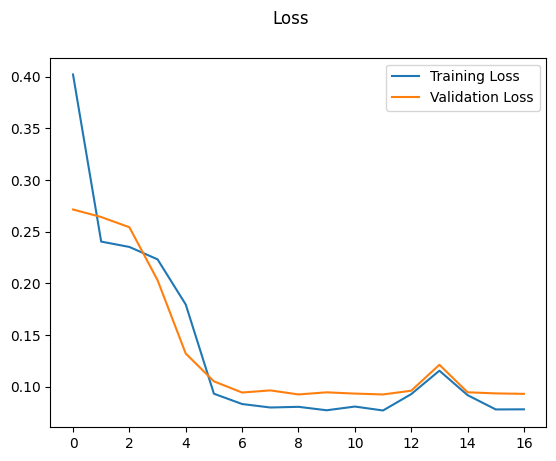

Result:

     Accuracy  F1 Score  Precision    Recall
492  0.979472  0.969539   0.979906  0.979472

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       442
      Normal       0.98      1.00      0.99     14929
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15686
   macro avg       0.66      0.66      0.66     15686
weighted avg       0.96      0.98      0.97     15686



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


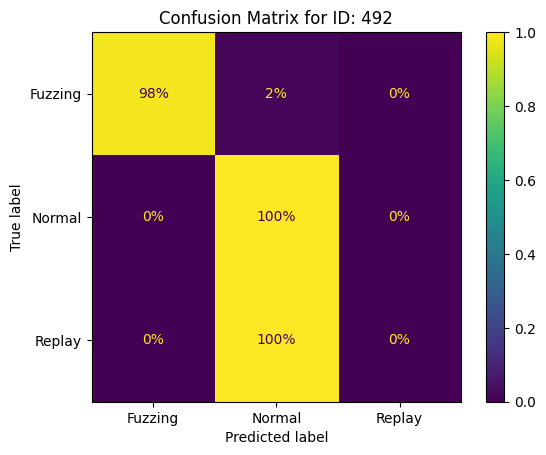

<Figure size 800x600 with 0 Axes>





Processing ID: 391
Epoch 1/20
181/181 [==============================] - 7s 16ms/step - loss: 0.2723 - accuracy: 0.9671 - val_loss: 0.1808 - val_accuracy: 0.9642
Epoch 2/20
181/181 [==============================] - 3s 15ms/step - loss: 0.1637 - accuracy: 0.9730 - val_loss: 0.1794 - val_accuracy: 0.9642
Epoch 3/20
181/181 [==============================] - 3s 16ms/step - loss: 0.1586 - accuracy: 0.9730 - val_loss: 0.1788 - val_accuracy: 0.9642
Epoch 4/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1558 - accuracy: 0.9730 - val_loss: 0.1780 - val_accuracy: 0.9642
Epoch 5/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1535 - accuracy: 0.9730 - val_loss: 0.1751 - val_accuracy: 0.9642
Epoch 6/20
181/181 [==============================] - 2s 10ms/step - loss: 0.1418 - accuracy: 0.9719 - val_loss: 0.1406 - val_accuracy: 0.9691
Epoch 7/20
181/181 [==============================] - 2s 10ms/step - loss: 0.0972 - accuracy: 0.9834 - val_loss: 0.1116

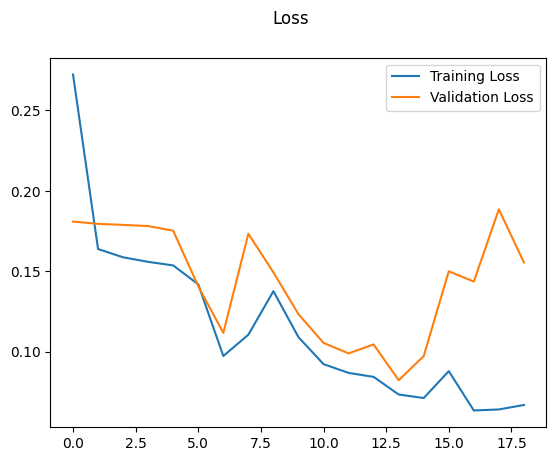

Result:

     Accuracy  F1 Score  Precision    Recall
391  0.974898  0.964355   0.975533  0.974898

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.65      0.78       513
      Normal       0.97      1.00      0.99     37341
      Replay       0.00      0.00      0.00       788

    accuracy                           0.97     38642
   macro avg       0.66      0.55      0.59     38642
weighted avg       0.96      0.97      0.96     38642



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


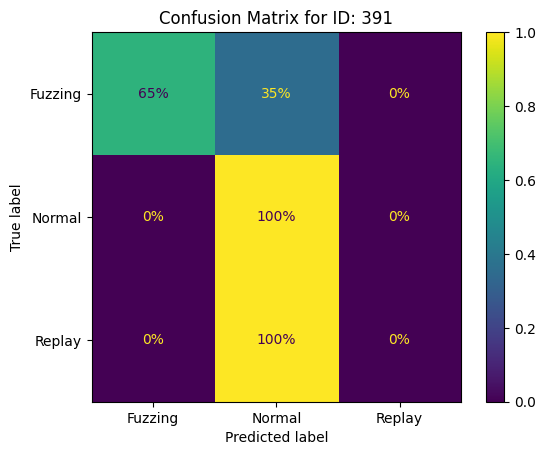

<Figure size 800x600 with 0 Axes>





Processing ID: 485
Epoch 1/20
75/75 [==============================] - 9s 29ms/step - loss: 0.4208 - accuracy: 0.9471 - val_loss: 0.2561 - val_accuracy: 0.9434
Epoch 2/20
75/75 [==============================] - 1s 14ms/step - loss: 0.2563 - accuracy: 0.9479 - val_loss: 0.2519 - val_accuracy: 0.9434
Epoch 3/20
75/75 [==============================] - 1s 13ms/step - loss: 0.2510 - accuracy: 0.9479 - val_loss: 0.2469 - val_accuracy: 0.9434
Epoch 4/20
75/75 [==============================] - 1s 13ms/step - loss: 0.2439 - accuracy: 0.9479 - val_loss: 0.2330 - val_accuracy: 0.9434
Epoch 5/20
75/75 [==============================] - 1s 19ms/step - loss: 0.2316 - accuracy: 0.9479 - val_loss: 0.2037 - val_accuracy: 0.9434
Epoch 6/20
75/75 [==============================] - 2s 22ms/step - loss: 0.1852 - accuracy: 0.9518 - val_loss: 0.1379 - val_accuracy: 0.9717
Epoch 7/20
75/75 [==============================] - 2s 21ms/step - loss: 0.0945 - accuracy: 0.9829 - val_loss: 0.1008 - val_accurac

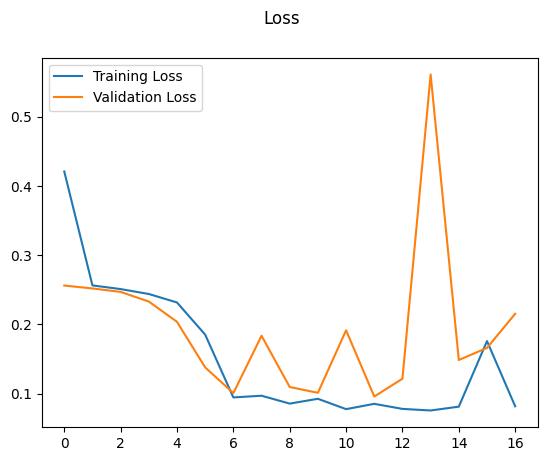

Result:

     Accuracy  F1 Score  Precision    Recall
485  0.975279  0.965208   0.975906  0.975279

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.85      0.92       473
      Normal       0.97      1.00      0.99     14907
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15695
   macro avg       0.66      0.62      0.63     15695
weighted avg       0.96      0.98      0.97     15695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


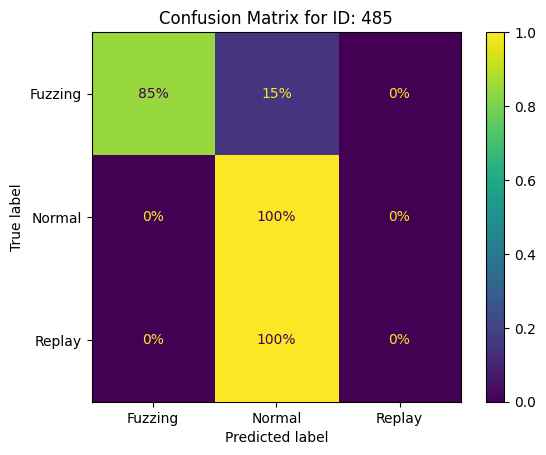

<Figure size 800x600 with 0 Axes>





Processing ID: 490
Epoch 1/20
75/75 [==============================] - 7s 25ms/step - loss: 0.4405 - accuracy: 0.9221 - val_loss: 0.2669 - val_accuracy: 0.9391
Epoch 2/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2506 - accuracy: 0.9479 - val_loss: 0.2296 - val_accuracy: 0.9391
Epoch 3/20
75/75 [==============================] - 1s 13ms/step - loss: 0.1678 - accuracy: 0.9623 - val_loss: 0.1142 - val_accuracy: 0.9764
Epoch 4/20
75/75 [==============================] - 1s 12ms/step - loss: 0.0811 - accuracy: 0.9867 - val_loss: 0.0946 - val_accuracy: 0.9818
Epoch 5/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0758 - accuracy: 0.9869 - val_loss: 0.0937 - val_accuracy: 0.9821
Epoch 6/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0756 - accuracy: 0.9869 - val_loss: 0.0930 - val_accuracy: 0.9821
Epoch 7/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0748 - accuracy: 0.9869 - val_loss: 0.0927 - val_accurac

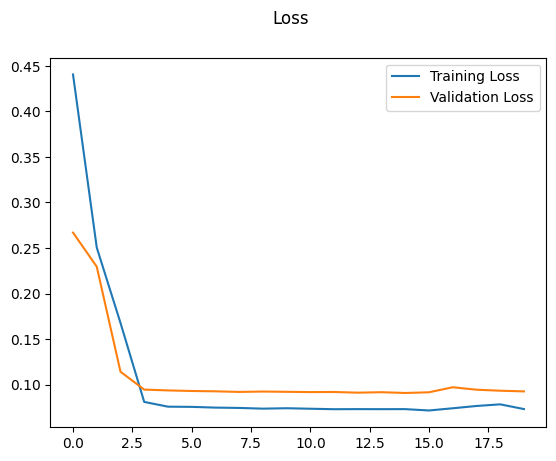

Result:

     Accuracy  F1 Score  Precision    Recall
490  0.979788  0.969883   0.980207  0.979788

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       497
      Normal       0.98      1.00      0.99     14921
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15733
   macro avg       0.66      0.66      0.66     15733
weighted avg       0.96      0.98      0.97     15733



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


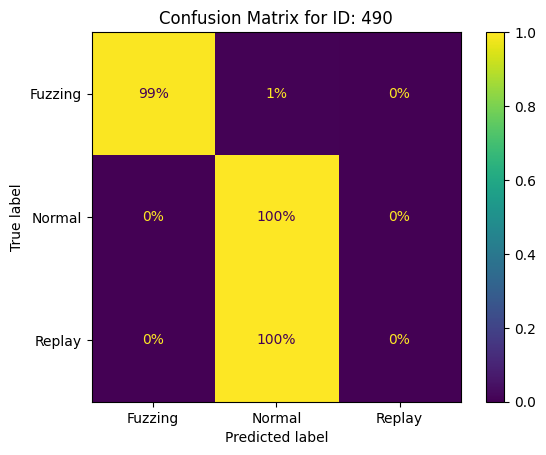

<Figure size 800x600 with 0 Axes>





Processing ID: 593
Epoch 1/20
21/21 [==============================] - 7s 92ms/step - loss: 0.7873 - accuracy: 0.7608 - val_loss: 0.6204 - val_accuracy: 0.8206
Epoch 2/20
21/21 [==============================] - 0s 16ms/step - loss: 0.4552 - accuracy: 0.8589 - val_loss: 0.4532 - val_accuracy: 0.8206
Epoch 3/20
21/21 [==============================] - 0s 16ms/step - loss: 0.3335 - accuracy: 0.8699 - val_loss: 0.2420 - val_accuracy: 0.9464
Epoch 4/20
21/21 [==============================] - 0s 19ms/step - loss: 0.1174 - accuracy: 0.9849 - val_loss: 0.1268 - val_accuracy: 0.9842
Epoch 5/20
21/21 [==============================] - 0s 18ms/step - loss: 0.0805 - accuracy: 0.9883 - val_loss: 0.0979 - val_accuracy: 0.9842
Epoch 6/20
21/21 [==============================] - 0s 13ms/step - loss: 0.0686 - accuracy: 0.9883 - val_loss: 0.0888 - val_accuracy: 0.9833
Epoch 7/20
21/21 [==============================] - 0s 16ms/step - loss: 0.0674 - accuracy: 0.9883 - val_loss: 0.0865 - val_accurac

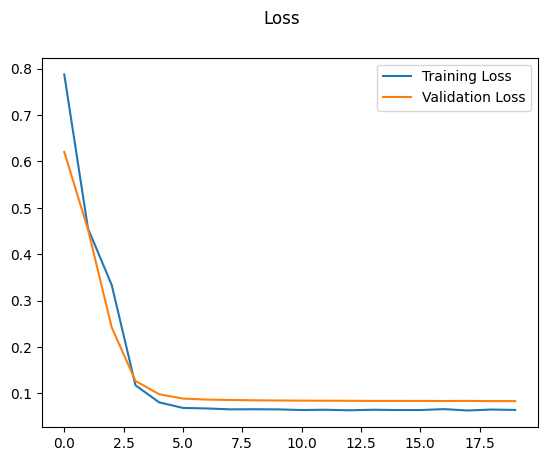

Result:

     Accuracy  F1 Score  Precision    Recall
593  0.981145  0.972167   0.981546  0.981145

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       485
      Normal       0.98      1.00      0.99      3733
      Replay       0.00      0.00      0.00        78

    accuracy                           0.98      4296
   macro avg       0.66      0.66      0.66      4296
weighted avg       0.96      0.98      0.97      4296



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


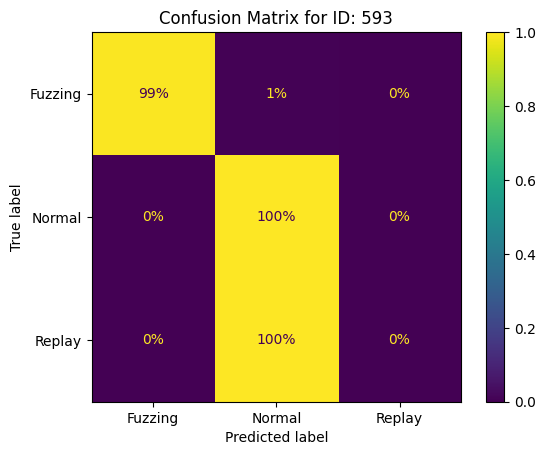

<Figure size 800x600 with 0 Axes>





Processing ID: 484
Epoch 1/20
54/54 [==============================] - 12s 78ms/step - loss: 0.4519 - accuracy: 0.9299 - val_loss: 0.3279 - val_accuracy: 0.9205
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2866 - accuracy: 0.9390 - val_loss: 0.3230 - val_accuracy: 0.9205
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2819 - accuracy: 0.9390 - val_loss: 0.3194 - val_accuracy: 0.9205
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2791 - accuracy: 0.9390 - val_loss: 0.3170 - val_accuracy: 0.9205
Epoch 5/20
54/54 [==============================] - 1s 13ms/step - loss: 0.2768 - accuracy: 0.9390 - val_loss: 0.3143 - val_accuracy: 0.9205
Epoch 6/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2717 - accuracy: 0.9390 - val_loss: 0.3080 - val_accuracy: 0.9205
Epoch 7/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2657 - accuracy: 0.9390 - val_loss: 0.2985 - val_accura

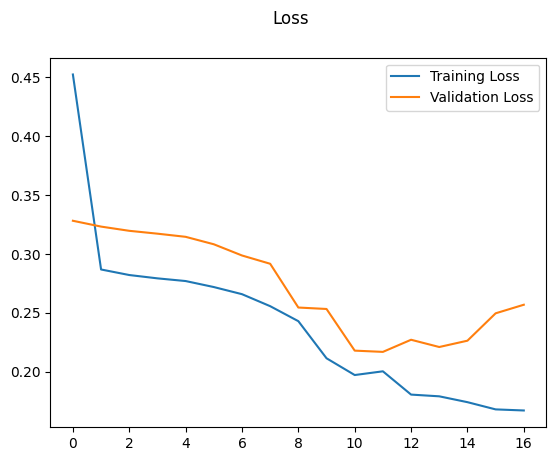

Result:

     Accuracy  F1 Score  Precision    Recall
484  0.937621  0.908118   0.941515  0.937621

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.02      0.03       492
      Normal       0.94      1.00      0.97     10649
      Replay       0.00      0.00      0.00       225

    accuracy                           0.94     11366
   macro avg       0.65      0.34      0.33     11366
weighted avg       0.92      0.94      0.91     11366



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


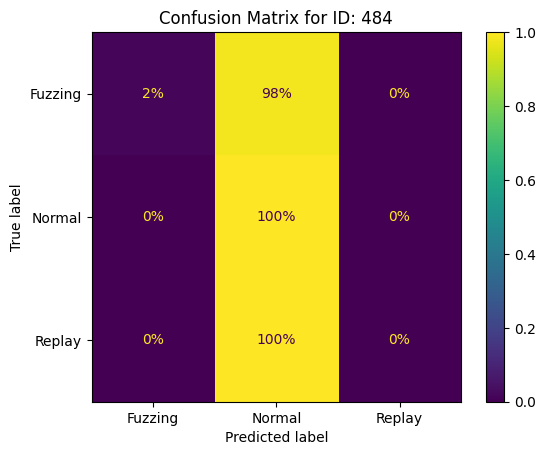

<Figure size 800x600 with 0 Axes>





Processing ID: 48A
Epoch 1/20
75/75 [==============================] - 8s 36ms/step - loss: 0.4096 - accuracy: 0.9467 - val_loss: 0.2639 - val_accuracy: 0.9432
Epoch 2/20
75/75 [==============================] - 1s 11ms/step - loss: 0.2653 - accuracy: 0.9469 - val_loss: 0.2594 - val_accuracy: 0.9432
Epoch 3/20
75/75 [==============================] - 1s 10ms/step - loss: 0.2593 - accuracy: 0.9469 - val_loss: 0.2568 - val_accuracy: 0.9432
Epoch 4/20
75/75 [==============================] - 1s 11ms/step - loss: 0.2556 - accuracy: 0.9469 - val_loss: 0.2553 - val_accuracy: 0.9432
Epoch 5/20
75/75 [==============================] - 1s 11ms/step - loss: 0.2522 - accuracy: 0.9469 - val_loss: 0.2542 - val_accuracy: 0.9432
Epoch 6/20
75/75 [==============================] - 1s 11ms/step - loss: 0.2514 - accuracy: 0.9469 - val_loss: 0.2533 - val_accuracy: 0.9432
Epoch 7/20
75/75 [==============================] - 1s 11ms/step - loss: 0.2491 - accuracy: 0.9469 - val_loss: 0.2525 - val_accurac

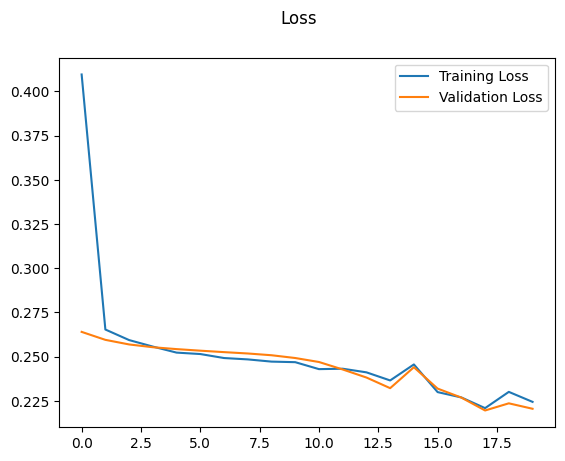

Result:

     Accuracy  F1 Score  Precision    Recall
48A  0.948459   0.92337   0.951115  0.948459

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       496
      Normal       0.95      1.00      0.97     14924
      Replay       0.00      0.00      0.00       315

    accuracy                           0.95     15735
   macro avg       0.32      0.33      0.32     15735
weighted avg       0.90      0.95      0.92     15735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


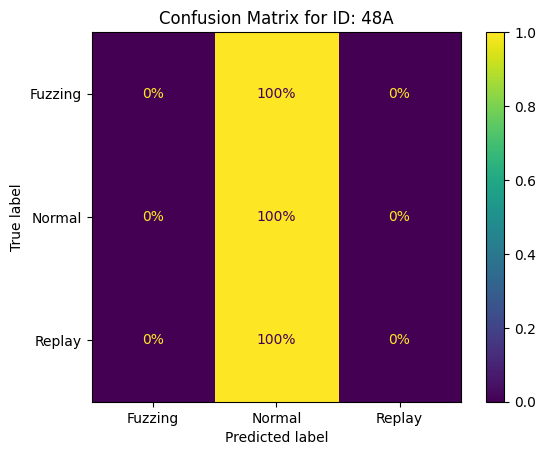

<Figure size 800x600 with 0 Axes>





Processing ID: 50C
Epoch 1/20
39/39 [==============================] - 8s 44ms/step - loss: 0.5730 - accuracy: 0.8752 - val_loss: 0.3825 - val_accuracy: 0.9022
Epoch 2/20
39/39 [==============================] - 1s 19ms/step - loss: 0.3507 - accuracy: 0.9172 - val_loss: 0.3636 - val_accuracy: 0.9022
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 0.3321 - accuracy: 0.9172 - val_loss: 0.3339 - val_accuracy: 0.9022
Epoch 4/20
39/39 [==============================] - 1s 19ms/step - loss: 0.2502 - accuracy: 0.9343 - val_loss: 0.1494 - val_accuracy: 0.9810
Epoch 5/20
39/39 [==============================] - 1s 20ms/step - loss: 0.0999 - accuracy: 0.9796 - val_loss: 0.1667 - val_accuracy: 0.9639
Epoch 6/20
39/39 [==============================] - 1s 20ms/step - loss: 0.4004 - accuracy: 0.9172 - val_loss: 0.3599 - val_accuracy: 0.9022
Epoch 7/20
39/39 [==============================] - 1s 20ms/step - loss: 0.3276 - accuracy: 0.9172 - val_loss: 0.3513 - val_accurac

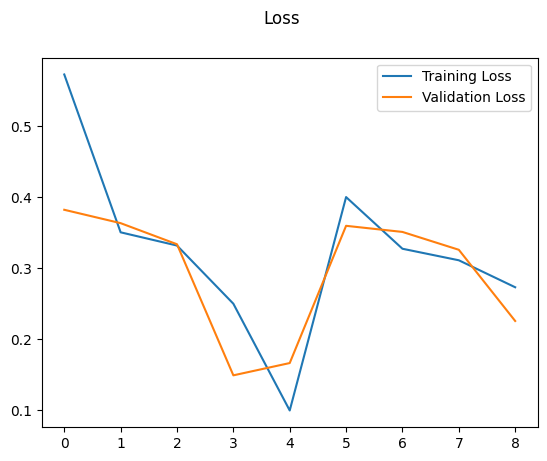

Result:

     Accuracy  F1 Score  Precision   Recall
50C   0.97619  0.966518   0.976792  0.97619

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.96       496
      Normal       0.97      1.00      0.99      7452
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8106
   macro avg       0.66      0.64      0.65      8106
weighted avg       0.96      0.98      0.97      8106



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


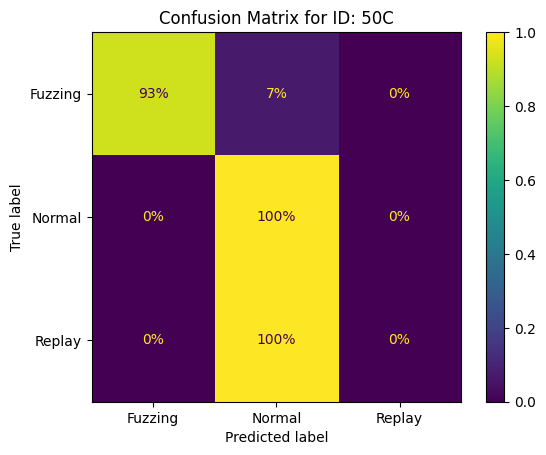

<Figure size 800x600 with 0 Axes>





Processing ID: 58B
Epoch 1/20
75/75 [==============================] - 9s 37ms/step - loss: 0.4186 - accuracy: 0.9452 - val_loss: 0.2741 - val_accuracy: 0.9371
Epoch 2/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2445 - accuracy: 0.9492 - val_loss: 0.2500 - val_accuracy: 0.9371
Epoch 3/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2073 - accuracy: 0.9394 - val_loss: 0.2385 - val_accuracy: 0.9371
Epoch 4/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2628 - accuracy: 0.9492 - val_loss: 0.2625 - val_accuracy: 0.9371
Epoch 5/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2006 - accuracy: 0.9492 - val_loss: 0.2073 - val_accuracy: 0.9371
Epoch 6/20
75/75 [==============================] - 1s 13ms/step - loss: 0.1802 - accuracy: 0.9554 - val_loss: 0.2744 - val_accuracy: 0.9371
Epoch 7/20
75/75 [==============================] - 1s 12ms/step - loss: 0.2041 - accuracy: 0.9553 - val_loss: 0.2073 - val_accurac

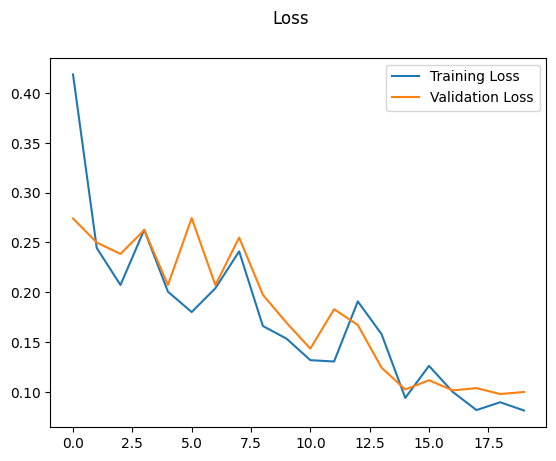

Result:

     Accuracy  F1 Score  Precision    Recall
58B  0.975198  0.965182   0.975832  0.975198

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.86      0.92       530
      Normal       0.97      1.00      0.99     14920
      Replay       0.00      0.00      0.00       315

    accuracy                           0.98     15765
   macro avg       0.66      0.62      0.64     15765
weighted avg       0.96      0.98      0.97     15765



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


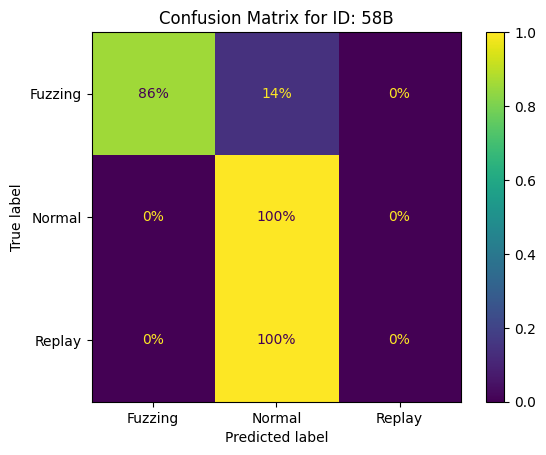

<Figure size 800x600 with 0 Axes>





Processing ID: 436
Epoch 1/20
74/74 [==============================] - 8s 25ms/step - loss: 0.4043 - accuracy: 0.9500 - val_loss: 0.2706 - val_accuracy: 0.9389
Epoch 2/20
74/74 [==============================] - 1s 12ms/step - loss: 0.2161 - accuracy: 0.9538 - val_loss: 0.1691 - val_accuracy: 0.9389
Epoch 3/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0907 - accuracy: 0.9812 - val_loss: 0.0932 - val_accuracy: 0.9819
Epoch 4/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0774 - accuracy: 0.9866 - val_loss: 0.0926 - val_accuracy: 0.9819
Epoch 5/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0769 - accuracy: 0.9866 - val_loss: 0.0919 - val_accuracy: 0.9819
Epoch 6/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0763 - accuracy: 0.9866 - val_loss: 0.0919 - val_accuracy: 0.9819
Epoch 7/20
74/74 [==============================] - 1s 12ms/step - loss: 0.0763 - accuracy: 0.9866 - val_loss: 0.0915 - val_accurac

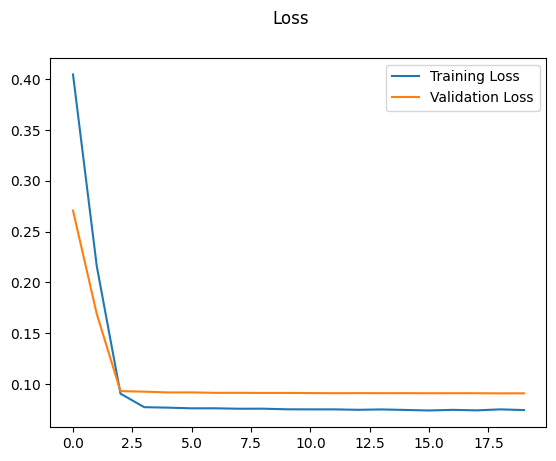

Result:

     Accuracy  F1 Score  Precision    Recall
436  0.979917  0.969981   0.980334  0.979917

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       503
      Normal       0.98      1.00      0.99     14916
      Replay       0.00      0.00      0.00       316

    accuracy                           0.98     15735
   macro avg       0.66      0.67      0.66     15735
weighted avg       0.96      0.98      0.97     15735



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


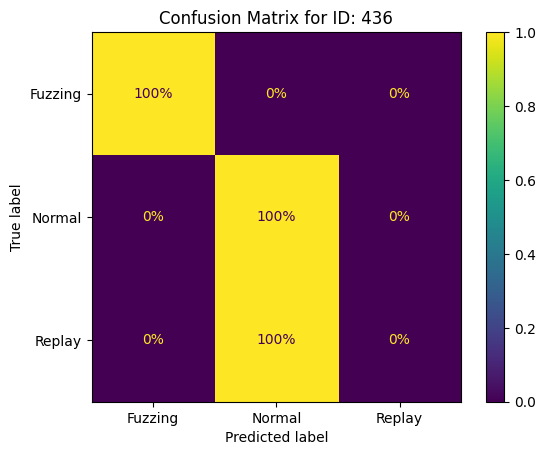

<Figure size 800x600 with 0 Axes>





Processing ID: 541
Epoch 1/20
41/41 [==============================] - 7s 53ms/step - loss: 0.5124 - accuracy: 0.9232 - val_loss: 0.3346 - val_accuracy: 0.9169
Epoch 2/20
41/41 [==============================] - 1s 22ms/step - loss: 0.3202 - accuracy: 0.9240 - val_loss: 0.3264 - val_accuracy: 0.9169
Epoch 3/20
41/41 [==============================] - 1s 25ms/step - loss: 0.3126 - accuracy: 0.9240 - val_loss: 0.3149 - val_accuracy: 0.9169
Epoch 4/20
41/41 [==============================] - 1s 30ms/step - loss: 0.2988 - accuracy: 0.9240 - val_loss: 0.2461 - val_accuracy: 0.9169
Epoch 5/20
41/41 [==============================] - 1s 23ms/step - loss: 0.1211 - accuracy: 0.9657 - val_loss: 0.0904 - val_accuracy: 0.9835
Epoch 6/20
41/41 [==============================] - 1s 22ms/step - loss: 0.0716 - accuracy: 0.9879 - val_loss: 0.0864 - val_accuracy: 0.9835
Epoch 7/20
41/41 [==============================] - 1s 17ms/step - loss: 0.0690 - accuracy: 0.9879 - val_loss: 0.0856 - val_accurac

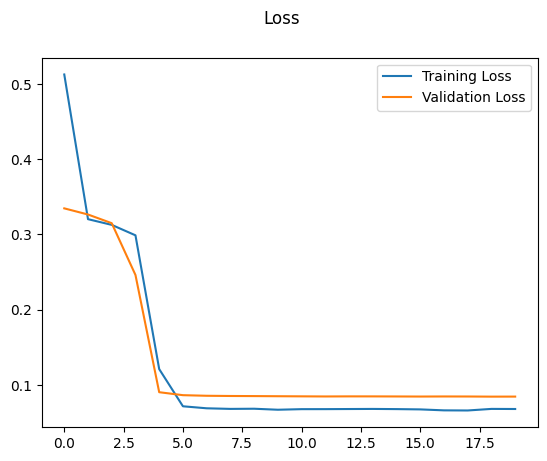

Result:

     Accuracy  F1 Score  Precision    Recall
541  0.981634  0.972542   0.981993  0.981634

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       521
      Normal       0.98      1.00      0.99      7924
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8603
   macro avg       0.66      0.67      0.66      8603
weighted avg       0.96      0.98      0.97      8603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


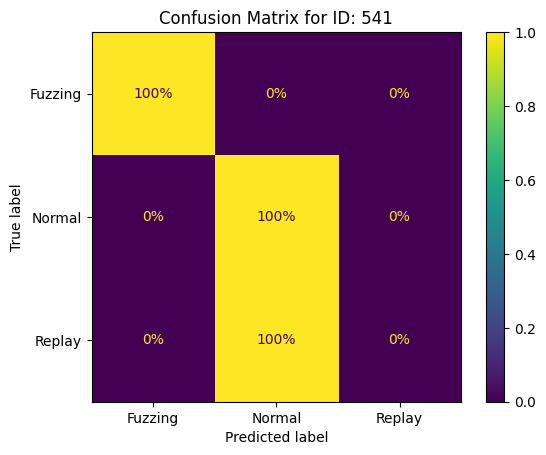

<Figure size 800x600 with 0 Axes>





Processing ID: 507
Epoch 1/20
39/39 [==============================] - 7s 56ms/step - loss: 0.5978 - accuracy: 0.8974 - val_loss: 0.3638 - val_accuracy: 0.9088
Epoch 2/20
39/39 [==============================] - 1s 19ms/step - loss: 0.3405 - accuracy: 0.9128 - val_loss: 0.2790 - val_accuracy: 0.9088
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 0.1666 - accuracy: 0.9613 - val_loss: 0.1166 - val_accuracy: 0.9819
Epoch 4/20
39/39 [==============================] - 1s 15ms/step - loss: 0.0788 - accuracy: 0.9872 - val_loss: 0.0907 - val_accuracy: 0.9829
Epoch 5/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0720 - accuracy: 0.9872 - val_loss: 0.0888 - val_accuracy: 0.9829
Epoch 6/20
39/39 [==============================] - 1s 14ms/step - loss: 0.0725 - accuracy: 0.9872 - val_loss: 0.0878 - val_accuracy: 0.9829
Epoch 7/20
39/39 [==============================] - 1s 13ms/step - loss: 0.0715 - accuracy: 0.9872 - val_loss: 0.0872 - val_accurac

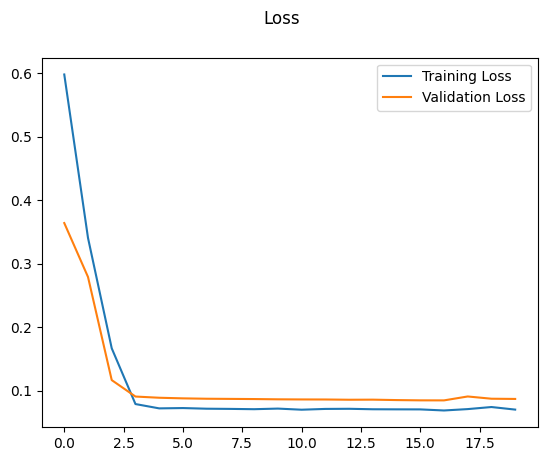

Result:

     Accuracy  F1 Score  Precision    Recall
507  0.980563  0.970947   0.980967  0.980563

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       514
      Normal       0.98      1.00      0.99      7457
      Replay       0.00      0.00      0.00       158

    accuracy                           0.98      8129
   macro avg       0.66      0.67      0.66      8129
weighted avg       0.96      0.98      0.97      8129



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


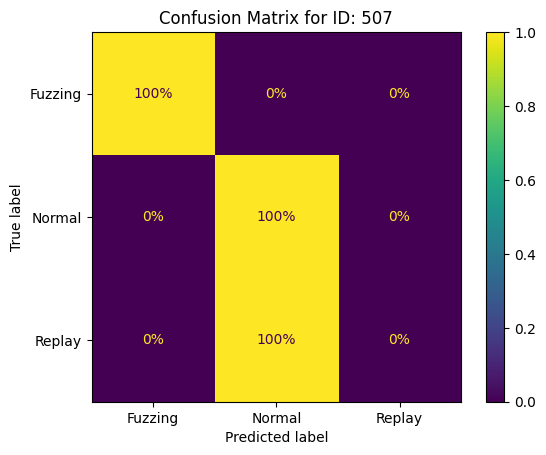

<Figure size 800x600 with 0 Axes>





Processing ID: 4A7
Epoch 1/20
10/10 [==============================] - 6s 126ms/step - loss: 0.9687 - accuracy: 0.6938 - val_loss: 0.8365 - val_accuracy: 0.6710
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.7277 - accuracy: 0.7329 - val_loss: 0.7445 - val_accuracy: 0.6710
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6699 - accuracy: 0.7329 - val_loss: 0.7060 - val_accuracy: 0.6710
Epoch 4/20
10/10 [==============================] - 0s 21ms/step - loss: 0.6425 - accuracy: 0.7329 - val_loss: 0.6904 - val_accuracy: 0.6710
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6373 - accuracy: 0.7329 - val_loss: 0.6909 - val_accuracy: 0.6710
Epoch 6/20
10/10 [==============================] - 0s 21ms/step - loss: 0.6380 - accuracy: 0.7329 - val_loss: 0.6915 - val_accuracy: 0.6710
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.6279 - accuracy: 0.7329 - val_loss: 0.6847 - val_accura

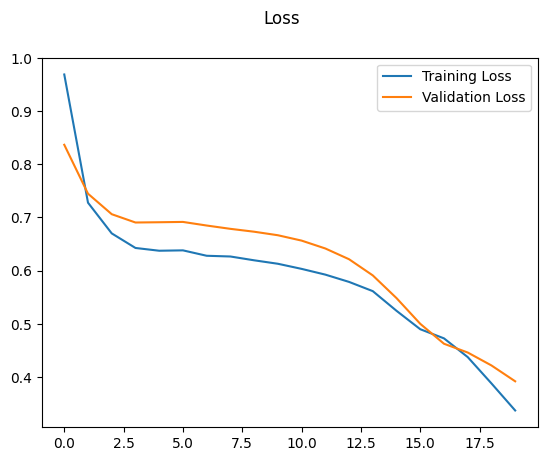

Result:

     Accuracy  F1 Score  Precision    Recall
4A7  0.794323  0.737281   0.838913  0.794323

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.21      0.35       484
      Normal       0.78      1.00      0.88      1492
      Replay       0.00      0.00      0.00        32

    accuracy                           0.79      2008
   macro avg       0.59      0.40      0.41      2008
weighted avg       0.82      0.79      0.74      2008



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


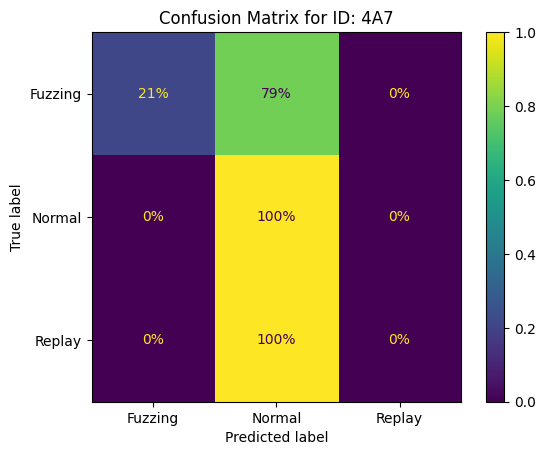

<Figure size 800x600 with 0 Axes>





Processing ID: 520
Epoch 1/20
39/39 [==============================] - 6s 38ms/step - loss: 0.5908 - accuracy: 0.8895 - val_loss: 0.4596 - val_accuracy: 0.8820
Epoch 2/20
39/39 [==============================] - 0s 13ms/step - loss: 0.3600 - accuracy: 0.9200 - val_loss: 0.4377 - val_accuracy: 0.8820
Epoch 3/20
39/39 [==============================] - 0s 12ms/step - loss: 0.3448 - accuracy: 0.9200 - val_loss: 0.4196 - val_accuracy: 0.8820
Epoch 4/20
39/39 [==============================] - 1s 13ms/step - loss: 0.3311 - accuracy: 0.9200 - val_loss: 0.4027 - val_accuracy: 0.8820
Epoch 5/20
39/39 [==============================] - 0s 13ms/step - loss: 0.3135 - accuracy: 0.9200 - val_loss: 0.3574 - val_accuracy: 0.8820
Epoch 6/20
39/39 [==============================] - 0s 12ms/step - loss: 0.2389 - accuracy: 0.9297 - val_loss: 0.1859 - val_accuracy: 0.9735
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 0.1353 - accuracy: 0.9775 - val_loss: 0.1679 - val_accurac

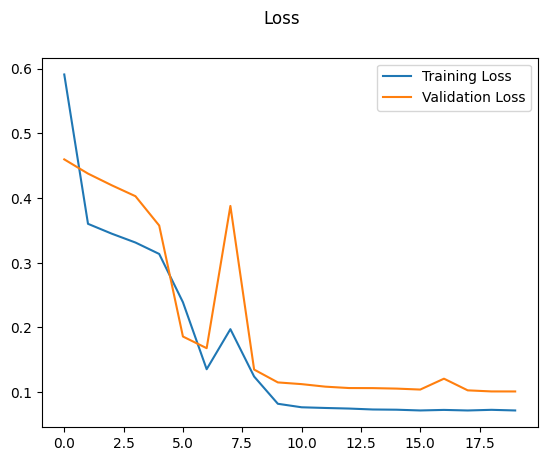

Result:

     Accuracy  F1 Score  Precision    Recall
520  0.972569   0.96274   0.973364  0.972569

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.87      0.93       502
      Normal       0.97      1.00      0.99      7433
      Replay       0.00      0.00      0.00       158

    accuracy                           0.97      8093
   macro avg       0.66      0.62      0.64      8093
weighted avg       0.95      0.97      0.96      8093



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


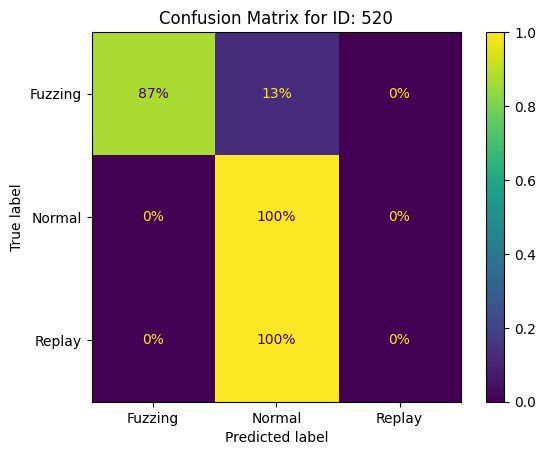

<Figure size 800x600 with 0 Axes>





Processing ID: 53E
Epoch 1/20
39/39 [==============================] - 7s 61ms/step - loss: 0.5977 - accuracy: 0.8790 - val_loss: 0.4017 - val_accuracy: 0.8987
Epoch 2/20
39/39 [==============================] - 1s 18ms/step - loss: 0.3681 - accuracy: 0.9127 - val_loss: 0.3803 - val_accuracy: 0.8987
Epoch 3/20
39/39 [==============================] - 1s 18ms/step - loss: 0.3498 - accuracy: 0.9127 - val_loss: 0.3572 - val_accuracy: 0.8987
Epoch 4/20
39/39 [==============================] - 1s 14ms/step - loss: 0.3159 - accuracy: 0.9127 - val_loss: 0.2771 - val_accuracy: 0.8987
Epoch 5/20
39/39 [==============================] - 1s 14ms/step - loss: 0.1635 - accuracy: 0.9541 - val_loss: 0.1426 - val_accuracy: 0.9830
Epoch 6/20
39/39 [==============================] - 1s 16ms/step - loss: 0.1542 - accuracy: 0.9710 - val_loss: 0.1178 - val_accuracy: 0.9744
Epoch 7/20
39/39 [==============================] - 1s 14ms/step - loss: 0.1206 - accuracy: 0.9712 - val_loss: 0.1037 - val_accurac

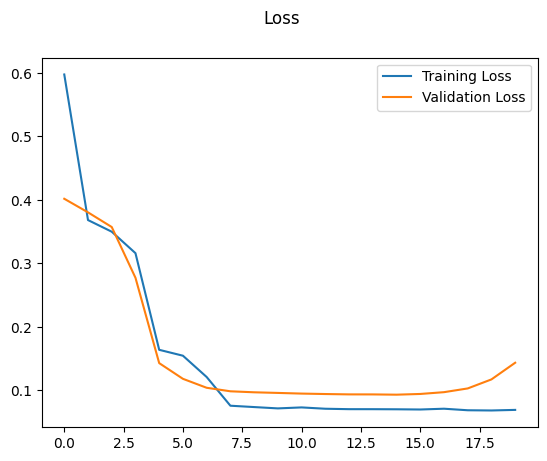

Result:

     Accuracy  F1 Score  Precision    Recall
53E  0.974031  0.964365   0.974745  0.974031

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.89      0.94       510
      Normal       0.97      1.00      0.99      7458
      Replay       0.00      0.00      0.00       157

    accuracy                           0.97      8125
   macro avg       0.66      0.63      0.64      8125
weighted avg       0.96      0.97      0.96      8125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


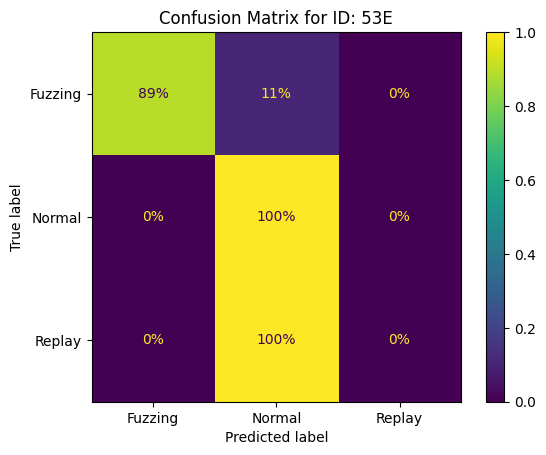

<Figure size 800x600 with 0 Axes>





Processing ID: 495
Epoch 1/20
38/38 [==============================] - 6s 39ms/step - loss: 0.5373 - accuracy: 0.9139 - val_loss: 0.3631 - val_accuracy: 0.9078
Epoch 2/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3214 - accuracy: 0.9275 - val_loss: 0.3604 - val_accuracy: 0.9078
Epoch 3/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3215 - accuracy: 0.9275 - val_loss: 0.3576 - val_accuracy: 0.9078
Epoch 4/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3180 - accuracy: 0.9275 - val_loss: 0.3564 - val_accuracy: 0.9078
Epoch 5/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3150 - accuracy: 0.9275 - val_loss: 0.3559 - val_accuracy: 0.9078
Epoch 6/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3151 - accuracy: 0.9275 - val_loss: 0.3554 - val_accuracy: 0.9078
Epoch 7/20
38/38 [==============================] - 0s 12ms/step - loss: 0.3129 - accuracy: 0.9275 - val_loss: 0.3553 - val_accurac

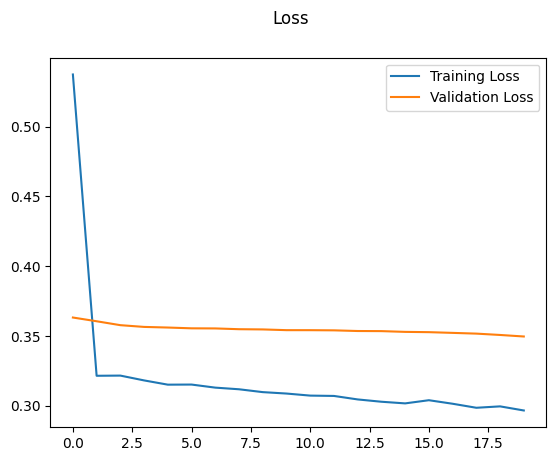

Result:

     Accuracy  F1 Score  Precision    Recall
495  0.922991  0.886029   0.928922  0.922991

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       465
      Normal       0.92      1.00      0.96      7455
      Replay       0.00      0.00      0.00       157

    accuracy                           0.92      8077
   macro avg       0.31      0.33      0.32      8077
weighted avg       0.85      0.92      0.89      8077



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


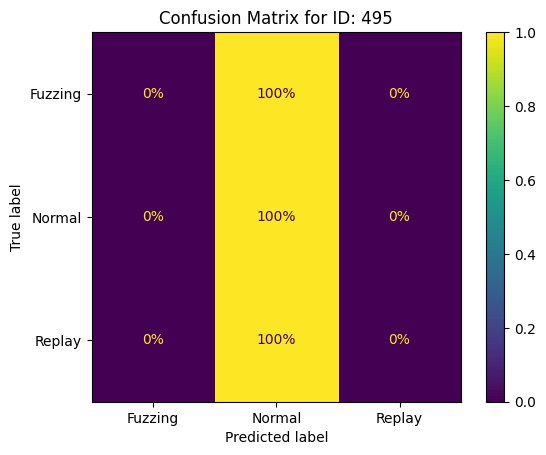

<Figure size 800x600 with 0 Axes>





Processing ID: 500
Epoch 1/20
39/39 [==============================] - 7s 40ms/step - loss: 0.5891 - accuracy: 0.8994 - val_loss: 0.3865 - val_accuracy: 0.9052
Epoch 2/20
39/39 [==============================] - 0s 12ms/step - loss: 0.3419 - accuracy: 0.9242 - val_loss: 0.3749 - val_accuracy: 0.9052
Epoch 3/20
39/39 [==============================] - 1s 13ms/step - loss: 0.3347 - accuracy: 0.9242 - val_loss: 0.3688 - val_accuracy: 0.9052
Epoch 4/20
39/39 [==============================] - 0s 12ms/step - loss: 0.3260 - accuracy: 0.9242 - val_loss: 0.3650 - val_accuracy: 0.9052
Epoch 5/20
39/39 [==============================] - 1s 13ms/step - loss: 0.3212 - accuracy: 0.9242 - val_loss: 0.3616 - val_accuracy: 0.9052
Epoch 6/20
39/39 [==============================] - 0s 12ms/step - loss: 0.3170 - accuracy: 0.9242 - val_loss: 0.3578 - val_accuracy: 0.9052
Epoch 7/20
39/39 [==============================] - 1s 13ms/step - loss: 0.3107 - accuracy: 0.9242 - val_loss: 0.3526 - val_accurac

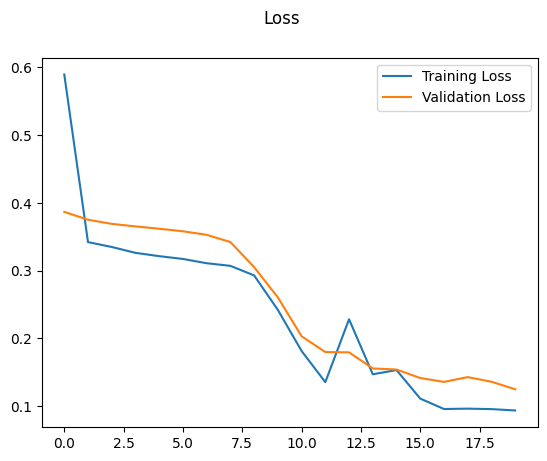

Result:

     Accuracy  F1 Score  Precision    Recall
500  0.971358  0.961571   0.972228  0.971358

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.86      0.92       533
      Normal       0.97      1.00      0.98      7445
      Replay       0.00      0.00      0.00       157

    accuracy                           0.97      8135
   macro avg       0.66      0.62      0.64      8135
weighted avg       0.95      0.97      0.96      8135



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


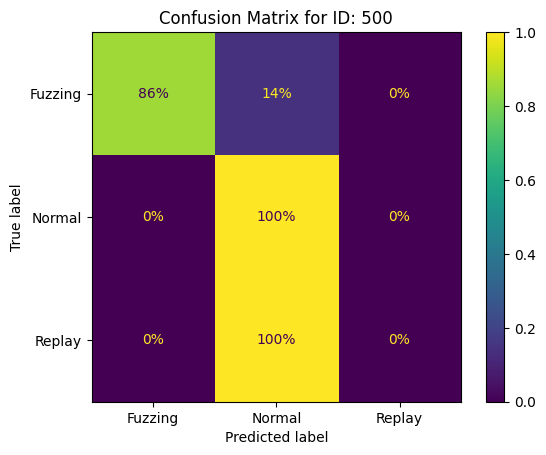

<Figure size 800x600 with 0 Axes>





Processing ID: 483
Epoch 1/20
22/22 [==============================] - 7s 61ms/step - loss: 0.6840 - accuracy: 0.8457 - val_loss: 0.5696 - val_accuracy: 0.8424
Epoch 2/20
22/22 [==============================] - 0s 15ms/step - loss: 0.4647 - accuracy: 0.8730 - val_loss: 0.4963 - val_accuracy: 0.8424
Epoch 3/20
22/22 [==============================] - 0s 13ms/step - loss: 0.4364 - accuracy: 0.8730 - val_loss: 0.4966 - val_accuracy: 0.8424
Epoch 4/20
22/22 [==============================] - 0s 14ms/step - loss: 0.4398 - accuracy: 0.8730 - val_loss: 0.4923 - val_accuracy: 0.8424
Epoch 5/20
22/22 [==============================] - 0s 15ms/step - loss: 0.4362 - accuracy: 0.8730 - val_loss: 0.4928 - val_accuracy: 0.8424
Epoch 6/20
22/22 [==============================] - 0s 16ms/step - loss: 0.4332 - accuracy: 0.8730 - val_loss: 0.4922 - val_accuracy: 0.8424
Epoch 7/20
22/22 [==============================] - 0s 13ms/step - loss: 0.4348 - accuracy: 0.8730 - val_loss: 0.4918 - val_accurac

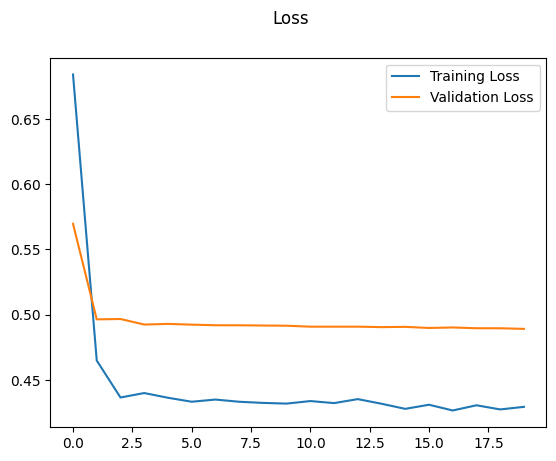

Result:

     Accuracy  F1 Score  Precision   Recall
483   0.86542  0.802985   0.883532  0.86542

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       504
      Normal       0.87      1.00      0.93      3749
      Replay       0.00      0.00      0.00        79

    accuracy                           0.87      4332
   macro avg       0.29      0.33      0.31      4332
weighted avg       0.75      0.87      0.80      4332



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


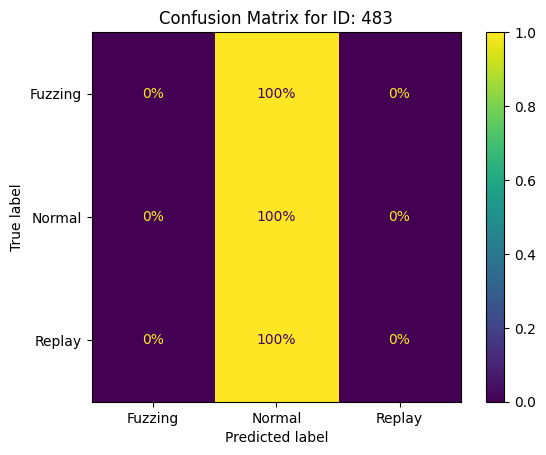

<Figure size 800x600 with 0 Axes>





Processing ID: 4A2
Epoch 1/20
11/11 [==============================] - 6s 118ms/step - loss: 0.9970 - accuracy: 0.6328 - val_loss: 0.8699 - val_accuracy: 0.6474
Epoch 2/20
11/11 [==============================] - 0s 19ms/step - loss: 0.7708 - accuracy: 0.7197 - val_loss: 0.7833 - val_accuracy: 0.6474
Epoch 3/20
11/11 [==============================] - 0s 19ms/step - loss: 0.6946 - accuracy: 0.7197 - val_loss: 0.7220 - val_accuracy: 0.6474
Epoch 4/20
11/11 [==============================] - 0s 19ms/step - loss: 0.6545 - accuracy: 0.7197 - val_loss: 0.6984 - val_accuracy: 0.6474
Epoch 5/20
11/11 [==============================] - 0s 19ms/step - loss: 0.6450 - accuracy: 0.7197 - val_loss: 0.6962 - val_accuracy: 0.6474
Epoch 6/20
11/11 [==============================] - 0s 20ms/step - loss: 0.6329 - accuracy: 0.7197 - val_loss: 0.6759 - val_accuracy: 0.6474
Epoch 7/20
11/11 [==============================] - 0s 23ms/step - loss: 0.6019 - accuracy: 0.7213 - val_loss: 0.6381 - val_accura

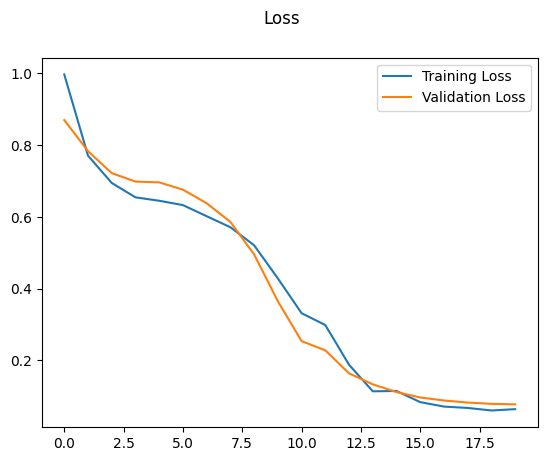

Result:

     Accuracy  F1 Score  Precision    Recall
4A2  0.849484  0.824077   0.875157  0.849484

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.47      0.64       513
      Normal       0.83      1.00      0.91      1488
      Replay       0.00      0.00      0.00        32

    accuracy                           0.85      2033
   macro avg       0.61      0.49      0.51      2033
weighted avg       0.86      0.85      0.82      2033



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


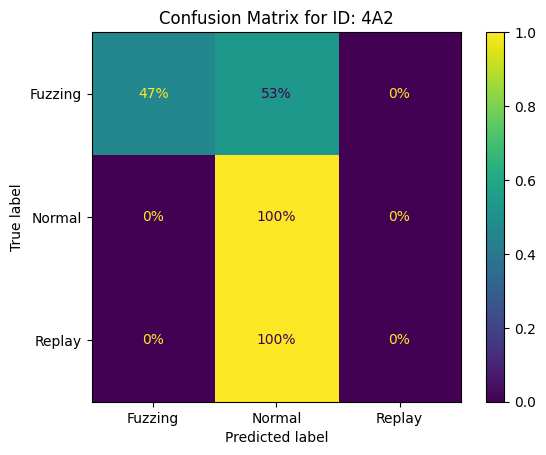

<Figure size 800x600 with 0 Axes>





Processing ID: 50A
Epoch 1/20
26/26 [==============================] - 10s 79ms/step - loss: 0.6891 - accuracy: 0.8379 - val_loss: 0.4885 - val_accuracy: 0.8631
Epoch 2/20
26/26 [==============================] - 1s 19ms/step - loss: 0.4323 - accuracy: 0.8805 - val_loss: 0.4567 - val_accuracy: 0.8631
Epoch 3/20
26/26 [==============================] - 0s 14ms/step - loss: 0.4300 - accuracy: 0.8805 - val_loss: 0.4520 - val_accuracy: 0.8631
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.4235 - accuracy: 0.8805 - val_loss: 0.4491 - val_accuracy: 0.8631
Epoch 5/20
26/26 [==============================] - 0s 14ms/step - loss: 0.4166 - accuracy: 0.8805 - val_loss: 0.4463 - val_accuracy: 0.8631
Epoch 6/20
26/26 [==============================] - 0s 14ms/step - loss: 0.4183 - accuracy: 0.8805 - val_loss: 0.4435 - val_accuracy: 0.8631
Epoch 7/20
26/26 [==============================] - 0s 13ms/step - loss: 0.4127 - accuracy: 0.8805 - val_loss: 0.4407 - val_accura

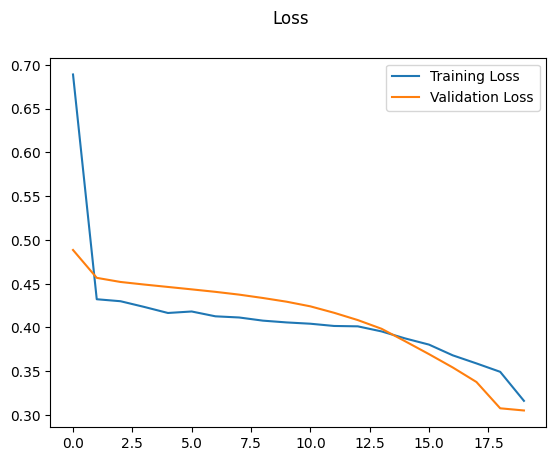

Result:

     Accuracy  F1 Score  Precision    Recall
50A  0.913636  0.885963    0.92126  0.913636

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.23      0.38       515
      Normal       0.91      1.00      0.95      4906
      Replay       0.00      0.00      0.00        79

    accuracy                           0.91      5500
   macro avg       0.64      0.41      0.44      5500
weighted avg       0.91      0.91      0.89      5500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


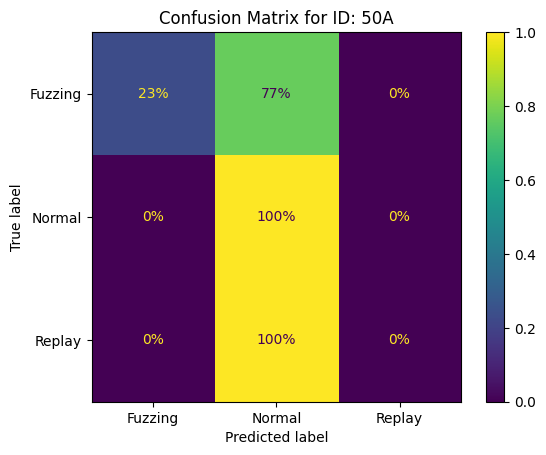

<Figure size 800x600 with 0 Axes>





Processing ID: 043
Epoch 1/20
10/10 [==============================] - 7s 135ms/step - loss: 1.0091 - accuracy: 0.5108 - val_loss: 0.7948 - val_accuracy: 0.6532
Epoch 2/20
10/10 [==============================] - 0s 23ms/step - loss: 0.6691 - accuracy: 0.5870 - val_loss: 0.4542 - val_accuracy: 0.6532
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 0.4383 - accuracy: 0.7238 - val_loss: 0.2529 - val_accuracy: 0.9919
Epoch 4/20
10/10 [==============================] - 0s 25ms/step - loss: 0.2220 - accuracy: 0.9939 - val_loss: 0.1011 - val_accuracy: 0.9919
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0722 - accuracy: 0.9939 - val_loss: 0.0585 - val_accuracy: 0.9919
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 0.0416 - accuracy: 0.9939 - val_loss: 0.0607 - val_accuracy: 0.9919
Epoch 7/20
10/10 [==============================] - 0s 24ms/step - loss: 0.0461 - accuracy: 0.9939 - val_loss: 0.0546 - val_accura

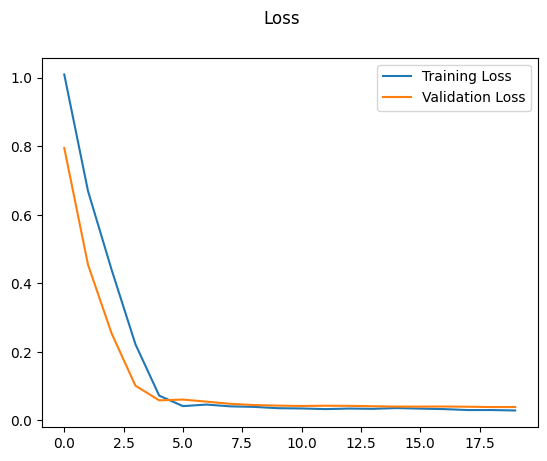

Result:

     Accuracy  F1 Score  Precision    Recall
043  0.989068   0.98367   0.989339  0.989068

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       972
      Normal       0.98      1.00      0.99       747
      Replay       0.00      0.00      0.00        19

    accuracy                           0.99      1738
   macro avg       0.66      0.67      0.66      1738
weighted avg       0.98      0.99      0.98      1738



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


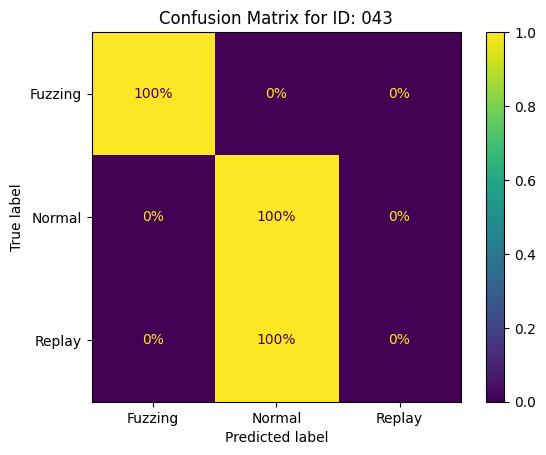

<Figure size 800x600 with 0 Axes>





Processing ID: 52A
Epoch 1/20
44/44 [==============================] - 6s 40ms/step - loss: 0.4700 - accuracy: 0.9184 - val_loss: 0.3314 - val_accuracy: 0.9117
Epoch 2/20
44/44 [==============================] - 1s 16ms/step - loss: 0.2602 - accuracy: 0.9315 - val_loss: 0.2338 - val_accuracy: 0.9117
Epoch 3/20
44/44 [==============================] - 1s 17ms/step - loss: 0.1261 - accuracy: 0.9668 - val_loss: 0.0917 - val_accuracy: 0.9866
Epoch 4/20
44/44 [==============================] - 1s 17ms/step - loss: 0.0496 - accuracy: 0.9937 - val_loss: 0.0755 - val_accuracy: 0.9879
Epoch 5/20
44/44 [==============================] - 1s 20ms/step - loss: 0.0427 - accuracy: 0.9943 - val_loss: 0.0714 - val_accuracy: 0.9879
Epoch 6/20
44/44 [==============================] - 1s 21ms/step - loss: 0.0396 - accuracy: 0.9943 - val_loss: 0.0700 - val_accuracy: 0.9879
Epoch 7/20
44/44 [==============================] - 1s 26ms/step - loss: 0.0389 - accuracy: 0.9943 - val_loss: 0.0692 - val_accurac

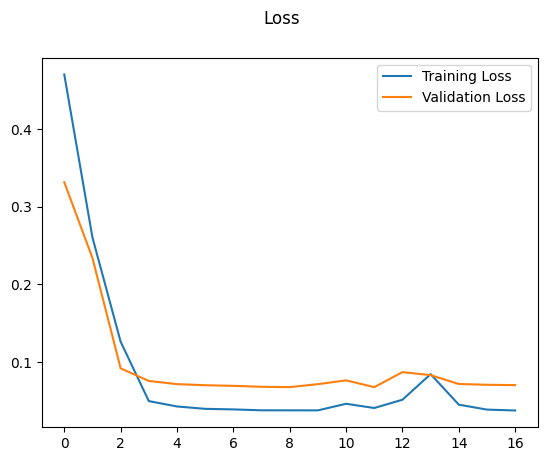

Result:

     Accuracy  F1 Score  Precision    Recall
52A  0.986113    0.9796   0.986316  0.986113

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       482
      Normal       0.99      1.00      0.99      8543
      Replay       0.00      0.00      0.00       120

    accuracy                           0.99      9145
   macro avg       0.66      0.66      0.66      9145
weighted avg       0.97      0.99      0.98      9145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


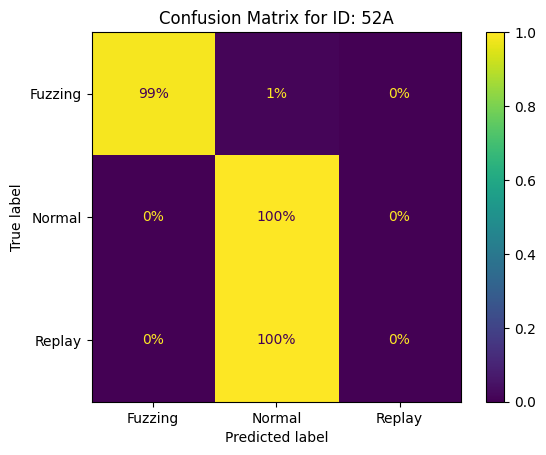

<Figure size 800x600 with 0 Axes>





Processing ID: 544
Epoch 1/20
21/21 [==============================] - 7s 66ms/step - loss: 0.6994 - accuracy: 0.8199 - val_loss: 0.5527 - val_accuracy: 0.8374
Epoch 2/20
21/21 [==============================] - 0s 16ms/step - loss: 0.4385 - accuracy: 0.8674 - val_loss: 0.4673 - val_accuracy: 0.8374
Epoch 3/20
21/21 [==============================] - 0s 16ms/step - loss: 0.4228 - accuracy: 0.8674 - val_loss: 0.4634 - val_accuracy: 0.8374
Epoch 4/20
21/21 [==============================] - 0s 15ms/step - loss: 0.4175 - accuracy: 0.8674 - val_loss: 0.4553 - val_accuracy: 0.8374
Epoch 5/20
21/21 [==============================] - 0s 15ms/step - loss: 0.4155 - accuracy: 0.8674 - val_loss: 0.4514 - val_accuracy: 0.8374
Epoch 6/20
21/21 [==============================] - 0s 16ms/step - loss: 0.4130 - accuracy: 0.8674 - val_loss: 0.4458 - val_accuracy: 0.8374
Epoch 7/20
21/21 [==============================] - 0s 15ms/step - loss: 0.4084 - accuracy: 0.8674 - val_loss: 0.4394 - val_accurac

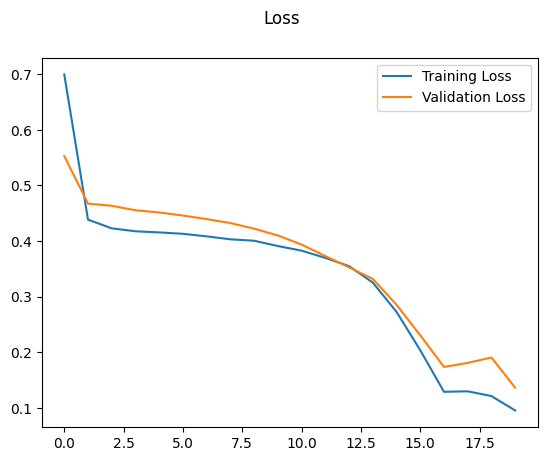

Result:

     Accuracy  F1 Score  Precision    Recall
544  0.957318  0.947283   0.959331  0.957318

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.80      0.89       513
      Normal       0.95      1.00      0.98      3719
      Replay       0.00      0.00      0.00        79

    accuracy                           0.96      4311
   macro avg       0.65      0.60      0.62      4311
weighted avg       0.94      0.96      0.95      4311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


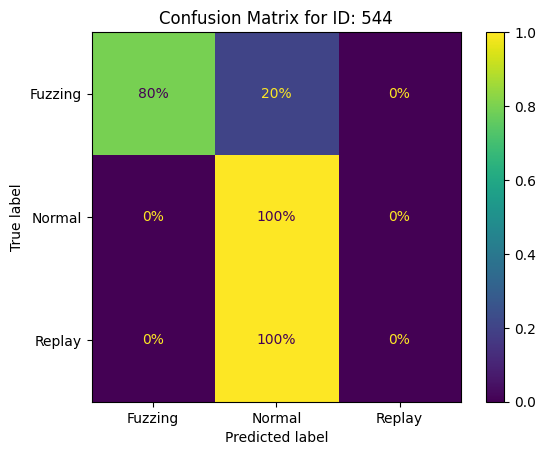

<Figure size 800x600 with 0 Axes>





Processing ID: 559
Epoch 1/20
21/21 [==============================] - 6s 66ms/step - loss: 0.8032 - accuracy: 0.8507 - val_loss: 0.5433 - val_accuracy: 0.8304
Epoch 2/20
21/21 [==============================] - 0s 16ms/step - loss: 0.4476 - accuracy: 0.8587 - val_loss: 0.4113 - val_accuracy: 0.8304
Epoch 3/20
21/21 [==============================] - 0s 17ms/step - loss: 0.2592 - accuracy: 0.9204 - val_loss: 0.1201 - val_accuracy: 0.9840
Epoch 4/20
21/21 [==============================] - 0s 17ms/step - loss: 0.0834 - accuracy: 0.9874 - val_loss: 0.0914 - val_accuracy: 0.9840
Epoch 5/20
21/21 [==============================] - 0s 18ms/step - loss: 0.0711 - accuracy: 0.9878 - val_loss: 0.0839 - val_accuracy: 0.9840
Epoch 6/20
21/21 [==============================] - 0s 17ms/step - loss: 0.0677 - accuracy: 0.9878 - val_loss: 0.0832 - val_accuracy: 0.9840
Epoch 7/20
21/21 [==============================] - 1s 25ms/step - loss: 0.0687 - accuracy: 0.9878 - val_loss: 0.0824 - val_accurac

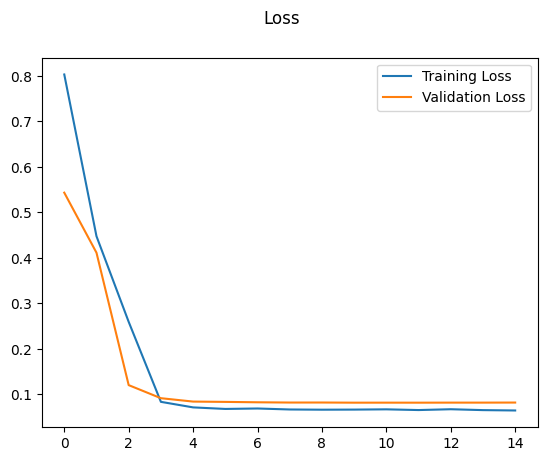

Result:

     Accuracy  F1 Score  Precision    Recall
559  0.981203  0.972022   0.981599  0.981203

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       459
      Normal       0.98      1.00      0.99      3718
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4256
   macro avg       0.66      0.67      0.66      4256
weighted avg       0.96      0.98      0.97      4256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


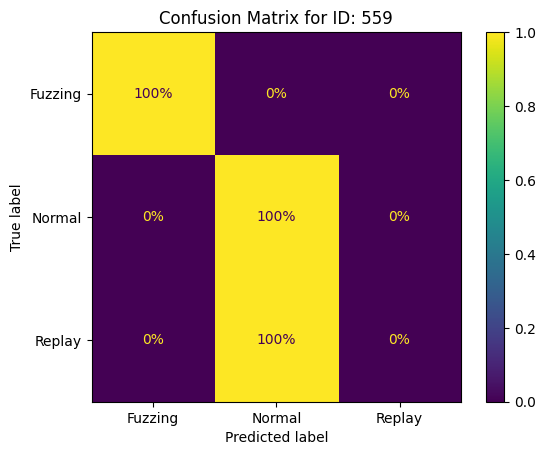

<Figure size 800x600 with 0 Axes>





Processing ID: 410
Epoch 1/20
21/21 [==============================] - 6s 68ms/step - loss: 0.8018 - accuracy: 0.7899 - val_loss: 0.5953 - val_accuracy: 0.8264
Epoch 2/20
21/21 [==============================] - 0s 19ms/step - loss: 0.5133 - accuracy: 0.8613 - val_loss: 0.5206 - val_accuracy: 0.8264
Epoch 3/20
21/21 [==============================] - 0s 19ms/step - loss: 0.4622 - accuracy: 0.8613 - val_loss: 0.5027 - val_accuracy: 0.8264
Epoch 4/20
21/21 [==============================] - 0s 20ms/step - loss: 0.4321 - accuracy: 0.8613 - val_loss: 0.4436 - val_accuracy: 0.8264
Epoch 5/20
21/21 [==============================] - 0s 21ms/step - loss: 0.3442 - accuracy: 0.8799 - val_loss: 0.2073 - val_accuracy: 0.9486
Epoch 6/20
21/21 [==============================] - 0s 18ms/step - loss: 0.1127 - accuracy: 0.9829 - val_loss: 0.1041 - val_accuracy: 0.9832
Epoch 7/20
21/21 [==============================] - 0s 21ms/step - loss: 0.2009 - accuracy: 0.9609 - val_loss: 0.5967 - val_accurac

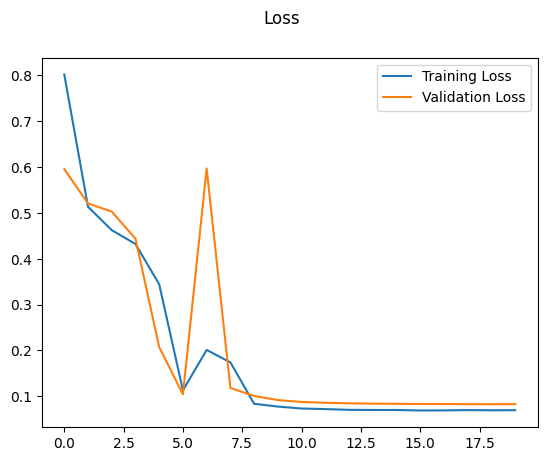

Result:

     Accuracy  F1 Score  Precision   Recall
410   0.98178  0.972766   0.982159  0.98178

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       531
      Normal       0.98      1.00      0.99      3726
      Replay       0.00      0.00      0.00        79

    accuracy                           0.98      4336
   macro avg       0.66      0.67      0.66      4336
weighted avg       0.96      0.98      0.97      4336



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


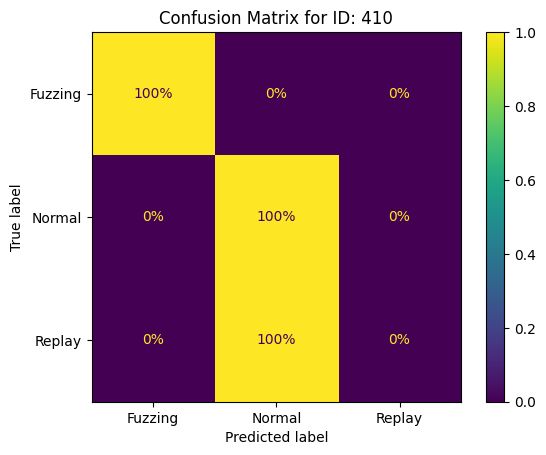

<Figure size 800x600 with 0 Axes>





Processing ID: 07F
Epoch 1/20
7/7 [==============================] - 7s 287ms/step - loss: 1.0591 - accuracy: 0.5394 - val_loss: 0.9504 - val_accuracy: 0.9914
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 0.8651 - accuracy: 0.8153 - val_loss: 0.6861 - val_accuracy: 0.4684
Epoch 3/20
7/7 [==============================] - 0s 31ms/step - loss: 0.6481 - accuracy: 0.4372 - val_loss: 0.5071 - val_accuracy: 0.5287
Epoch 4/20
7/7 [==============================] - 0s 31ms/step - loss: 0.4353 - accuracy: 0.8966 - val_loss: 0.2257 - val_accuracy: 0.9914
Epoch 5/20
7/7 [==============================] - 0s 32ms/step - loss: 0.1570 - accuracy: 0.9926 - val_loss: 0.0685 - val_accuracy: 0.9914
Epoch 6/20
7/7 [==============================] - 0s 36ms/step - loss: 0.0595 - accuracy: 0.9926 - val_loss: 0.0603 - val_accuracy: 0.9914
Epoch 7/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0532 - accuracy: 0.9926 - val_loss: 0.0555 - val_accuracy: 0.9914
Epo

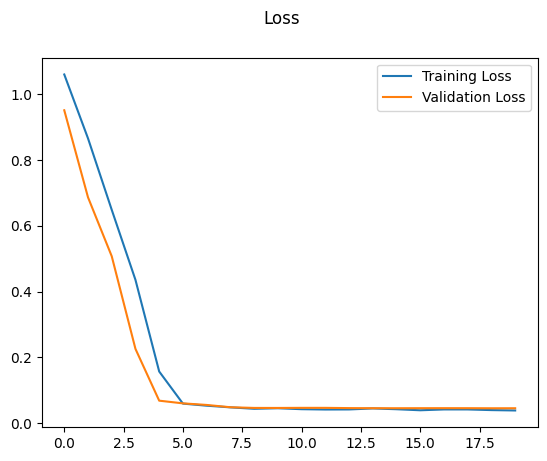

Result:

     Accuracy  F1 Score  Precision    Recall
07F  0.987597  0.981461   0.987857  0.987597

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       527
      Normal       0.98      1.00      0.99       747
      Replay       0.00      0.00      0.00        16

    accuracy                           0.99      1290
   macro avg       0.66      0.67      0.66      1290
weighted avg       0.98      0.99      0.98      1290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


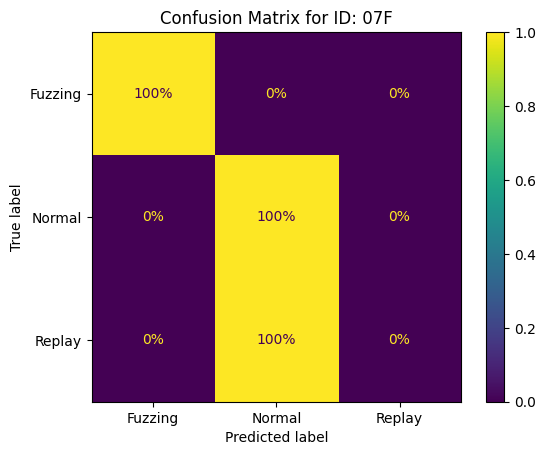

<Figure size 800x600 with 0 Axes>





Processing ID: 57F
Epoch 1/20
5/5 [==============================] - 10s 942ms/step - loss: 1.0427 - accuracy: 0.5436 - val_loss: 0.9523 - val_accuracy: 0.6842
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.9251 - accuracy: 0.5662 - val_loss: 0.8124 - val_accuracy: 0.6842
Epoch 3/20
5/5 [==============================] - 0s 25ms/step - loss: 0.8026 - accuracy: 0.5697 - val_loss: 0.6854 - val_accuracy: 0.6842
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 0.7272 - accuracy: 0.5679 - val_loss: 0.6478 - val_accuracy: 0.6842
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 0.7241 - accuracy: 0.5645 - val_loss: 0.6657 - val_accuracy: 0.6842
Epoch 6/20
5/5 [==============================] - 0s 23ms/step - loss: 0.7170 - accuracy: 0.5418 - val_loss: 0.6767 - val_accuracy: 0.6842
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.7124 - accuracy: 0.5575 - val_loss: 0.6647 - val_accuracy: 0.6842
Ep

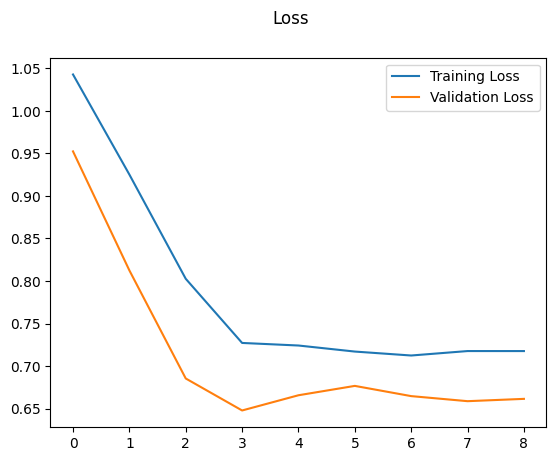

Result:

     Accuracy  F1 Score  Precision    Recall
57F  0.579418  0.425126   0.756307  0.579418

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.58      1.00      0.73       518
      Normal       0.00      0.00      0.00       369
      Replay       0.00      0.00      0.00         7

    accuracy                           0.58       894
   macro avg       0.19      0.33      0.24       894
weighted avg       0.34      0.58      0.43       894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


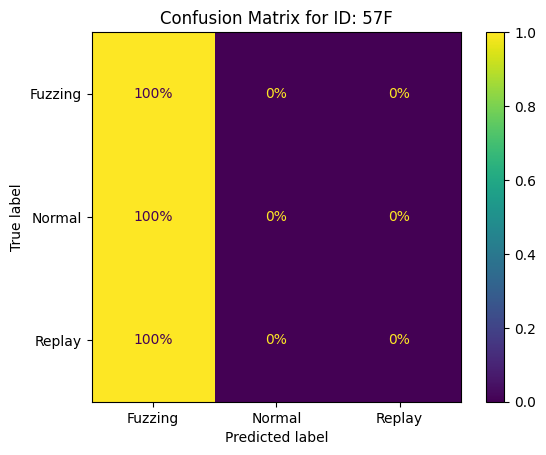

<Figure size 800x600 with 0 Axes>





Processing ID: 5B0
Epoch 1/20
7/7 [==============================] - 7s 189ms/step - loss: 1.0675 - accuracy: 0.4694 - val_loss: 0.9829 - val_accuracy: 0.4629
Epoch 2/20
7/7 [==============================] - 0s 24ms/step - loss: 0.9360 - accuracy: 0.5674 - val_loss: 0.8688 - val_accuracy: 0.4629
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.8170 - accuracy: 0.5833 - val_loss: 0.7878 - val_accuracy: 0.4629
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 0.7494 - accuracy: 0.5809 - val_loss: 0.7391 - val_accuracy: 0.4629
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.7146 - accuracy: 0.6140 - val_loss: 0.6950 - val_accuracy: 0.8200
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6832 - accuracy: 0.6961 - val_loss: 0.6747 - val_accuracy: 0.8543
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6546 - accuracy: 0.7402 - val_loss: 0.6495 - val_accuracy: 0.8171
Epo

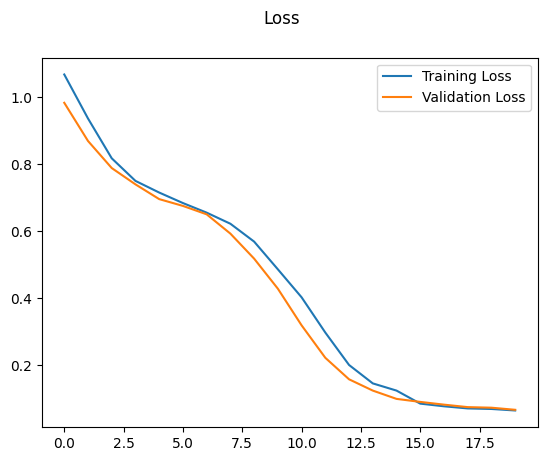

Result:

     Accuracy  F1 Score  Precision    Recall
5B0  0.886943   0.87849   0.905062  0.886943

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.74      0.85       497
      Normal       0.84      1.00      0.91       744
      Replay       0.00      0.00      0.00        15

    accuracy                           0.89      1256
   macro avg       0.61      0.58      0.59      1256
weighted avg       0.89      0.89      0.88      1256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


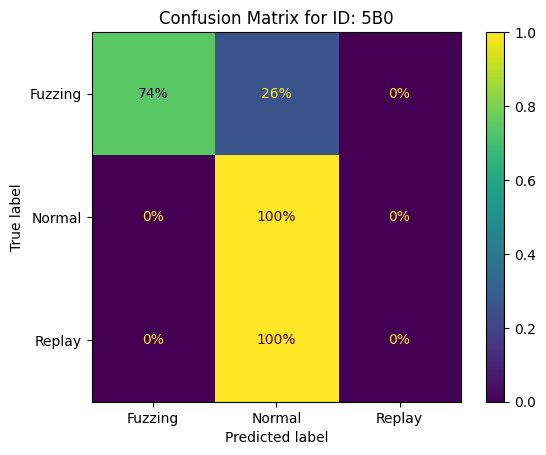

<Figure size 800x600 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

id_total_results = pd.DataFrame()

for data_id in ids:
    print(f"Processing ID: {data_id}")
    X_train, X_test, y_train, y_test, class_labels = id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id)
    y_pred = model_train(X_train, X_test, y_train, y_test, class_labels)
    evaluation_results={}

    # 각 모델에 대해 예측을 수행하고 평가 지표를 계산
    # Acccuracy, precision, recall, f1-score 계산
    modelAcc_1= accuracy_score(y_test, y_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=1.0)

    # 결과를 딕셔너리에 저장
    evaluation_results[data_id] = {
        'Accuracy': modelAcc_1,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    print('Result:\n')
    print(pd.DataFrame(evaluation_results).T)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # 혼동 행렬 계산 및 시각화
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_labels, normalize='true', values_format='.0%')

    # 시각화
    plt.title(f'Confusion Matrix for ID: {data_id}')
    #disp.plot(cmap=plt.cm.Blues)
    plt.figure(figsize=(8, 6))
    #cm = confusion_matrix(y_test, y_pred)
    plt.show()
    print("\n" + "="*80 + "\n")

    # 각 아이디별, 모델별 결과 저장
    id_total_results = pd.concat([id_total_results, pd.DataFrame(evaluation_results)], axis=1)
    print("\n" + "="*80 + "\n")

### 모든 ID들의 성능의 평균치 계산
- Accuracy, F1-score, Precision의 평균 계산

In [ ]:
id_total_results

,251,2B0,381,340,260,47F,329,164,387,394,...,4A2,50A,043,52A,544,559,410,07F,57F,5B0
Accuracy,0.975095,0.976900,0.976484,0.973267,0.996788,0.966541,0.972780,0.976248,0.970285,0.979097,...,0.849484,0.913636,0.989068,0.986113,0.957318,0.981203,0.981780,0.987597,0.579418,0.886943
F1 Score,0.965099,0.966705,0.966228,0.960419,0.996696,0.950096,0.959357,0.965953,0.957813,0.968986,...,0.824077,0.885963,0.983670,0.979600,0.947283,0.972022,0.972766,0.981461,0.425126,0.878490
Precision,0.975680,0.957080,0.977043,0.973982,0.996770,0.967660,0.973521,0.976818,0.971110,0.979539,...,0.875157,0.921260,0.989339,0.986316,0.959331,0.981599,0.982159,0.987857,0.756307,0.905062
Recall,0.975095,0.976900,0.976484,0.973267,0.996788,0.966541,0.972780,0.976248,0.970285,0.979097,...,0.849484,0.913636,0.989068,0.986113,0.957318,0.981203,0.981780,0.987597,0.579418,0.886943


In [ ]:
id_total_results.mean(axis='columns')

Accuracy     0.955816
F1 Score     0.939186
Precision    0.961677
Recall       0.955816
dtype: float64

In [ ]:
output_file = '/content/drive/MyDrive/CAN/submit_filter_data/LSTM_performance_scores_by_id.csv'
id_total_results.to_csv(output_file, index=False)